<a href="https://colab.research.google.com/github/BarbaraAngelesOrtiz/Challenge3-Alura-Store/blob/main/TelecomX_LATAM2_es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telecom X - Desarrollar modelos predictivos de Fuga de Clientes

🎯 Misión: Desarrollar modelos predictivos capaces de prever qué clientes tienen mayor probabilidad de cancelar sus servicios.

La empresa quiere anticiparse al problema de la cancelación, y la finalidad es construir un pipeline robusto para esta etapa inicial de modelado.

🧠 Objetivos del Desafío

* Preparar los datos para el modelado (tratamiento, codificación, normalización).

* Realizar análisis de correlación y selección de variables.

* Entrenar dos o más modelos de clasificación.

* Evaluar el rendimiento de los modelos con métricas.

* Interpretar los resultados, incluyendo la importancia de las variables.

* Crear una conclusión estratégica señalando los principales factores que influyen en la cancelación.

🧰 Lo que se hará:

 1. Preprocesamiento de datos para Machine Learning
 2. Construcción y evaluación de modelos predictivos
 3. Interpretación de resultados y entrega de insights
 4. Comunicación técnica con enfoque estratégico


## 📂Extracción del Archivo Tratado previamente en TelecomX LATAM

 Se carga el archivo CSV que contiene los datos tratados anteriormente.Este archivo que se limpió y organizó en la Parte 1 del desafío Telecom X contiene solo las columnas relevantes, ya con los datos corregidos y estandarizados.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')

# URL RAW del JSON
url = "https://raw.githubusercontent.com/BarbaraAngelesOrtiz/Challenge3-Alura-Store/refs/heads/main/dataset.csv"

# Cargar directamente el JSON desde la URL a un DataFrame
df = pd.read_csv(url)

## 🔍 **EDA (Análisis exploratorio inicial)**

* Ver info general

* Estadísticas descriptivas de variables numéricas

* Revisión de variables categóricas (frecuencias)

* Revisión de nulos

* Histogramas y boxplots para numéricas

* Gráficos de barras para categóricas

In [3]:
# Info general
print("\nInformación general:")
print(df.info())


Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   customerID                         7043 non-null   object 
 1   Churn                              7043 non-null   int64  
 2   customer_gender                    7043 non-null   int64  
 3   customer_SeniorCitizen             7043 non-null   int64  
 4   customer_Partner                   7043 non-null   int64  
 5   customer_Dependents                7043 non-null   int64  
 6   customer_tenure                    7043 non-null   int64  
 7   phone_PhoneService                 7043 non-null   int64  
 8   phone_MultipleLines                7043 non-null   int64  
 9   internet_OnlineSecurity            7043 non-null   int64  
 10  internet_OnlineBackup              7043 non-null   int64  
 11  internet_DeviceProtection         

In [4]:
# Revisar valores nulos
print("\nValores nulos por columna:")
print(df.isnull().sum())

# Separar columnas numéricas y categóricas
numericas = df.select_dtypes(include=['int64', 'float64']).columns
categoricas = df.select_dtypes(include=['object', 'category']).columns

# Estadísticas descriptivas - numéricas
print("\nEstadísticas descriptivas - Variables numéricas:")
print(df[numericas].describe())

# Frecuencia de valores - categóricas
print("\nFrecuencia de valores - Variables categóricas:")
for col in categoricas:
    print(f"\nColumna: {col}")
    print(df[col].value_counts())


Valores nulos por columna:
customerID                           0
Churn                                0
customer_gender                      0
customer_SeniorCitizen               0
customer_Partner                     0
customer_Dependents                  0
customer_tenure                      0
phone_PhoneService                   0
phone_MultipleLines                  0
internet_OnlineSecurity              0
internet_OnlineBackup                0
internet_DeviceProtection            0
internet_TechSupport                 0
internet_StreamingTV                 0
internet_StreamingMovies             0
account_PaperlessBilling             0
MonthlyCharges                       0
TotalCharges                         0
Internet_DSL                         0
Internet_Fiber optic                 0
Internet_No                          0
Contract_Month-to-month              0
Contract_One year                    0
Contract_Two year                    0
Payment_Bank transfer (automatic)   

**Observaciones del primer análisis de EDA**

🔍 1. **Datos nulos**

No hay valores nulos en ninguna columna, asi se evita tener que imputar o eliminar datos. El dataset está completo y limpio en cuanto a nulos.

🔍 2. **Variables categóricas**

customerID tiene valores únicos para cada fila (7043 distintos). Por lo tanto no aporta valor predictivo directamente (es solo un identificador).

🔍 3. **Variable objetivo: Churn**

* Churn tiene media de ~0.265, lo que indica que ~26.5% de los clientes abandonaron.

🔍 4. **Variables binarias (0/1)**

Muchas variables están codificadas como 0 y 1, lo cual es muy útil.

Por ejemplo:

* customer_gender: balanceado (~50/50).

* customer_SeniorCitizen: solo ~16% son adultos mayores → puede ser una minoría interesante para segmentar.

* phone_PhoneService: ~90% tienen servicio telefónico.

* internet_OnlineSecurity, internet_OnlineBackup, internet_TechSupport: todas con baja proporción de usuarios (~28%-34%). Podrían correlacionarse con retención o cancelación.

* Métodos de pago también están bien codificados: por ejemplo, el método más común parece ser Electronic check (33.6%).

🔍 5. **Variables continuas**

1. customer_tenure:

* Rango: 0 a 72 meses.

* Mediana: ~29 meses → muchas personas ya son clientes de más de 2 años.

* Valores 0 indican nuevos clientes.

2. MonthlyCharges y TotalCharges:

* MonthlyCharges tiene distribución más uniforme.

* TotalCharges varía ampliamente, podría estar correlacionada fuertemente con tenure.
------


### **Distribución de Churn (abandono)**

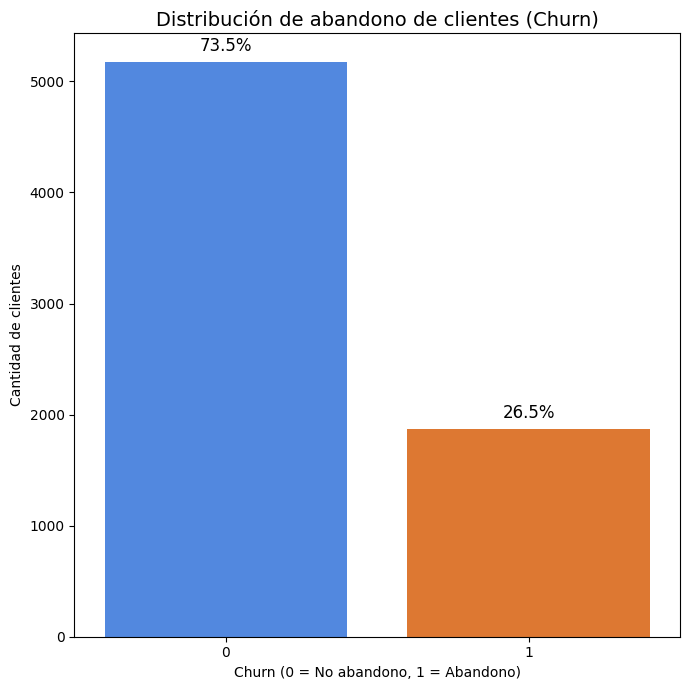

In [5]:
# Definimos los colores en un diccionario para usar durante todo el análisis
churn_palette = {
    0: '#3B82F6',  # Azul (no abandono)
    1: '#F97316'   # Naranja (abandono)
}

# Conteo y porcentaje
churn_counts = df['Churn'].value_counts().sort_index()
churn_percent = churn_counts / churn_counts.sum() * 100

# Gráfico
plt.figure(figsize=(7, 7))
bars = sns.barplot(
    x=churn_counts.index,
    y=churn_counts.values,
    palette=[churn_palette[i] for i in churn_counts.index]
)

plt.title('Distribución de abandono de clientes (Churn)', fontsize=14)
plt.xlabel('Churn (0 = No abandono, 1 = Abandono)')
plt.ylabel('Cantidad de clientes')

# Anotar porcentajes encima de las barras
for i, val in enumerate(churn_counts.values):
    plt.text(i, val + 100, f"{churn_percent[i]:.1f}%", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

**Observaciones**

Se confirma que al Churn tener media de ~0.265, es decir que ~26.5% de los clientes abandonaron, es un dataset desbalanceado, con más clientes que no cancelaron (73.5%).

Esto puede ser importante para modelos de clasificación: puede requerir técnicas de balanceo (como SMOTE, undersampling, class weights, etc.).

---

### **Histograma de Variables númericas no binarias**

Las variables numéricas que no son binarias (0 o 1) en tu dataset son:

* customer_tenure

* MonthlyCharges

* TotalCharges

📌 Se aplica la fórmula de Doane para determinar un número ajustado de bins considerando la asimetría (skewness) de los datos. Se añade una línea de densidad (Kernel Density Estimate, KDE) sobre el histograma y visualizar mejor la forma de la distribución.

Siendo la interpretación rápida de skewness:

🔹Skew = 0 → distribución simétrica (como una campana).

🔹Skew > 0 → cola a la derecha (valores extremos positivos).

🔹Skew < 0 → cola a la izquierda (valores extremos negativos).



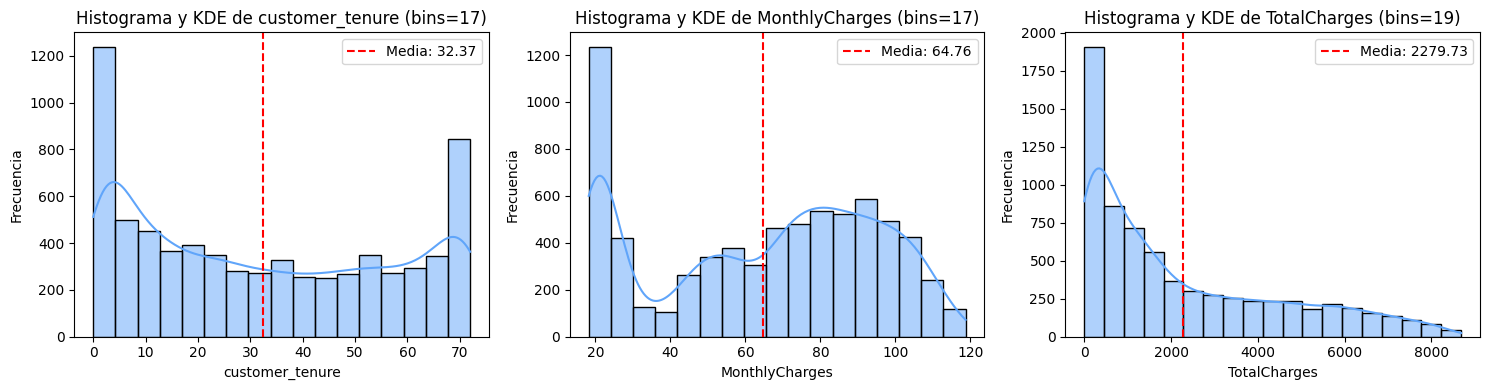



Asimetría (skewness) de variables continuas:

- customer_tenure: 0.24 → simétrica a la derecha
- MonthlyCharges: -0.22 → simétrica a la izquierda
- TotalCharges: 0.96 → ligeramente sesgada a la derecha


In [6]:
from scipy.stats import skew

# Función para calcular el número de bins según Doane
def calcular_bins_doane(serie):
    n = len(serie)
    g1 = skew(serie, bias=False)
    sigma_g1 = np.sqrt(6 * (n - 2) / ((n + 1) * (n + 3)))
    k = 1 + np.log2(n) + np.log2(1 + abs(g1) / sigma_g1)
    return int(round(k))

variables_continuas = ['customer_tenure', 'MonthlyCharges', 'TotalCharges']

plt.figure(figsize=(15, 4))

for i, col in enumerate(variables_continuas):
    plt.subplot(1, 3, i + 1)
    serie = df[col].dropna()
    bins = calcular_bins_doane(serie)

    sns.histplot(serie, bins=bins, color="#60A5FA", edgecolor='black', kde=True)

    mean_val = serie.mean()
    plt.axvline(mean_val, color='red', linestyle='--', label=f'Media: {mean_val:.2f}')

    plt.title(f'Histograma y KDE de {col} (bins={bins})')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.legend()

plt.tight_layout()
plt.show()


variables_continuas = ['customer_tenure', 'MonthlyCharges', 'TotalCharges']

print("\n\nAsimetría (skewness) de variables continuas:\n")
for var in variables_continuas:
    valor_skew = skew(df[var], bias=False)
    forma = (
        "simétrica" if abs(valor_skew) < 0.5 else
        "ligeramente sesgada" if abs(valor_skew) < 1 else
        "muy sesgada"
    )
    direccion = "a la derecha" if valor_skew > 0 else "a la izquierda" if valor_skew < 0 else ""
    print(f"- {var}: {valor_skew:.2f} → {forma} {direccion}")


**Observaciones**

1. customer_tenure (skew = 0.24 → simétrica a la derecha)

Está casi simétrica, pero con una leve inclinación hacia la derecha. Esto indica que la mayoría de clientes tiene una antigüedad cercana a la mediana, pero hay algunos clientes con tenures mayores (colas hacia valores altos). No es un sesgo muy fuerte, por lo que se podría tratarla como casi normal para análisis simples.

2. MonthlyCharges (skew = -0.22 → simétrica a la izquierda)

También bastante cercana a simétrica, pero con ligera inclinación hacia la izquierda. Esto indica que la mayoría paga montos medios o altos, pero hay un pequeño grupo con cargos mensuales bajos (cola hacia valores bajos). Puede reflejar diferentes planes o paquetes con precios más bajos para algunos clientes.

3. TotalCharges (skew = 0.96 → ligeramente sesgada a la derecha)

Aquí sí hay una asimetría más notable hacia la derecha. Esto significa que hay una cola relativamente larga de clientes con cargos totales muy altos. Es lógico porque TotalCharges está relacionado con la duración del contrato (tenure) y el cargo mensual.

Esta variable puede tener valores extremos (clientes antiguos con muchas facturas acumuladas). Podría ser útil considerar transformaciones (logarítmicas) si se usa en modelos sensibles a sesgos.

---

### **Boxplots por variable, segmentados por Churn**

Muestra mediana, cuartiles y posibles outliers por grupo Churn, asi se compara tendencias y dispersión.

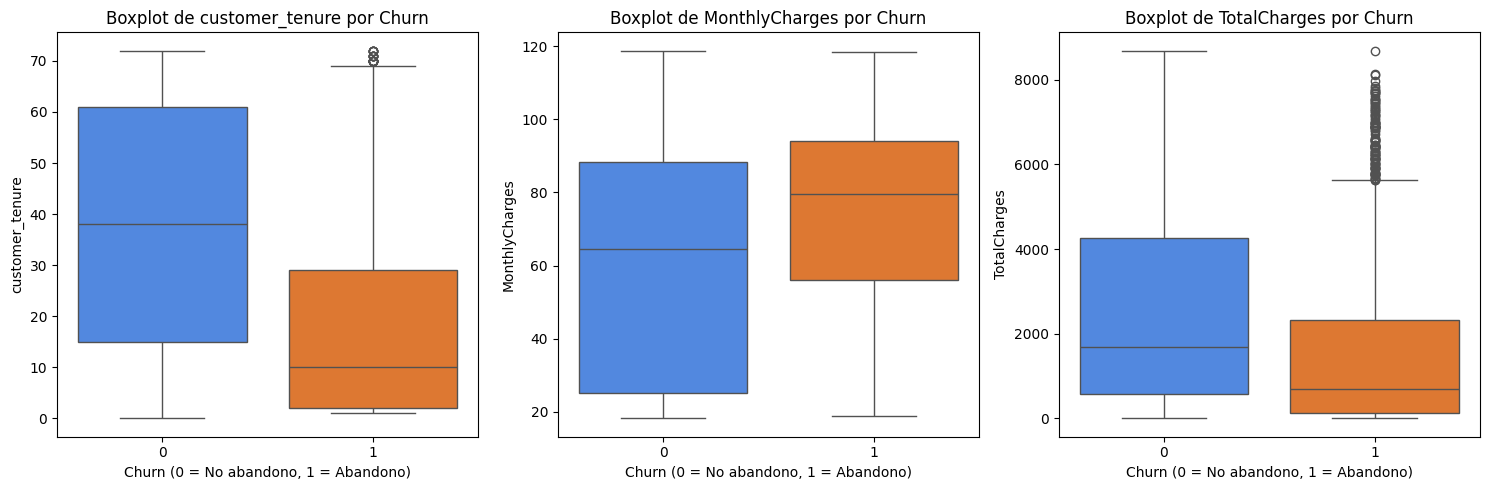

In [7]:
variables_continuas = ['customer_tenure', 'MonthlyCharges', 'TotalCharges']

plt.figure(figsize=(15, 5))

for i, col in enumerate(variables_continuas):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(x='Churn', y=col, data=df, palette={'0': '#3B82F6', '1': '#F97316'})
    plt.title(f'Boxplot de {col} por Churn')
    plt.xlabel('Churn (0 = No abandono, 1 = Abandono)')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

**Observaciones**

🔸customer_tenure (tiempo como cliente):

* Los clientes que no abandonaron (Churn=0) tienen una mediana mucho más alta de tiempo como cliente que los que abandonaron.

* Los que abandonan (Churn=1) tienden a ser clientes nuevos (mediana ~10), mientras que los que se quedan tienen mayor antigüedad (mediana ~38).

* Esto sugiere que el abandono ocurre con más frecuencia en los primeros meses de servicio.

🔸MonthlyCharges (cargos mensuales):

* Los que abandonan tienen cargos mensuales más altos, en general.

* La mediana de cargos mensuales es mayor en los clientes que abandonan.

* Es posible que los clientes con servicios más costosos estén menos satisfechos o vean menos valor por el precio.

🔸TotalCharges (cargos acumulados):

* Los clientes que no abandonan tienen un TotalCharges mucho más alto, lo cual es esperable ya que llevan más tiempo.

* Los que abandonan tienen un total acumulado bajo, en línea con el poco tiempo como clientes.

-----

### **FacetGrid con histogramas y KDE para cada variable por Churn**

Muestra la forma completa de la distribución para clientes que abandonaron y los que no, con solapamiento para comparar mejor.

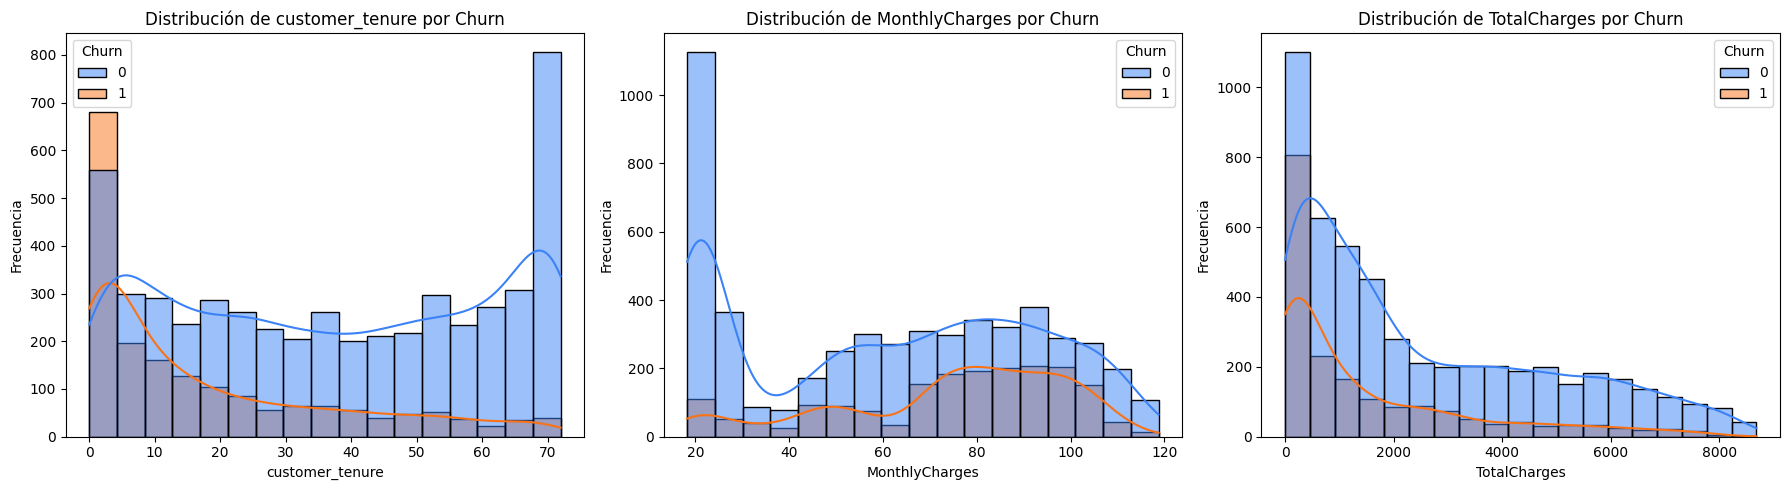

In [8]:
variables_continuas = ['customer_tenure', 'MonthlyCharges', 'TotalCharges']

plt.figure(figsize=(18, 5))

for i, col in enumerate(variables_continuas):
    plt.subplot(1, 3, i + 1)
    bins = calcular_bins_doane(df[col].dropna())
    sns.histplot(
        data=df,
        x=col,
        hue='Churn',
        bins=bins,
        kde=True,
        palette=churn_palette,
        alpha=0.5,
        edgecolor='black'
    )
    plt.title(f'Distribución de {col} por Churn')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

**Observaciones**

🔸customer_tenure:

* Gran cantidad de clientes que abandonan lo hacen en los primeros meses (0-10 meses).

* La distribución de los que no abandonan es más dispersa y con picos crecientes a mayor tiempo de permanencia.

🔸MonthlyCharges:

* Los clientes que abandonan tienden a concentrarse más en el rango de cargos mensuales entre 70 y 100, mientras que los que no abandonan están más distribuidos.

* Muchos clientes que no abandonan tienen cargos bajos (~20-30), lo que podría asociarse a planes básicos más estables.

🔸TotalCharges:

* La mayoría de los que abandonan tienen cargos totales muy bajos (<2000), lo cual confirma que se van temprano en su ciclo de vida como cliente.

* Los que no abandonan tienen una distribución más amplia y extendida hasta >8000.

----

### **Gráficas de barras de variables categóricas binarias vs Churn**

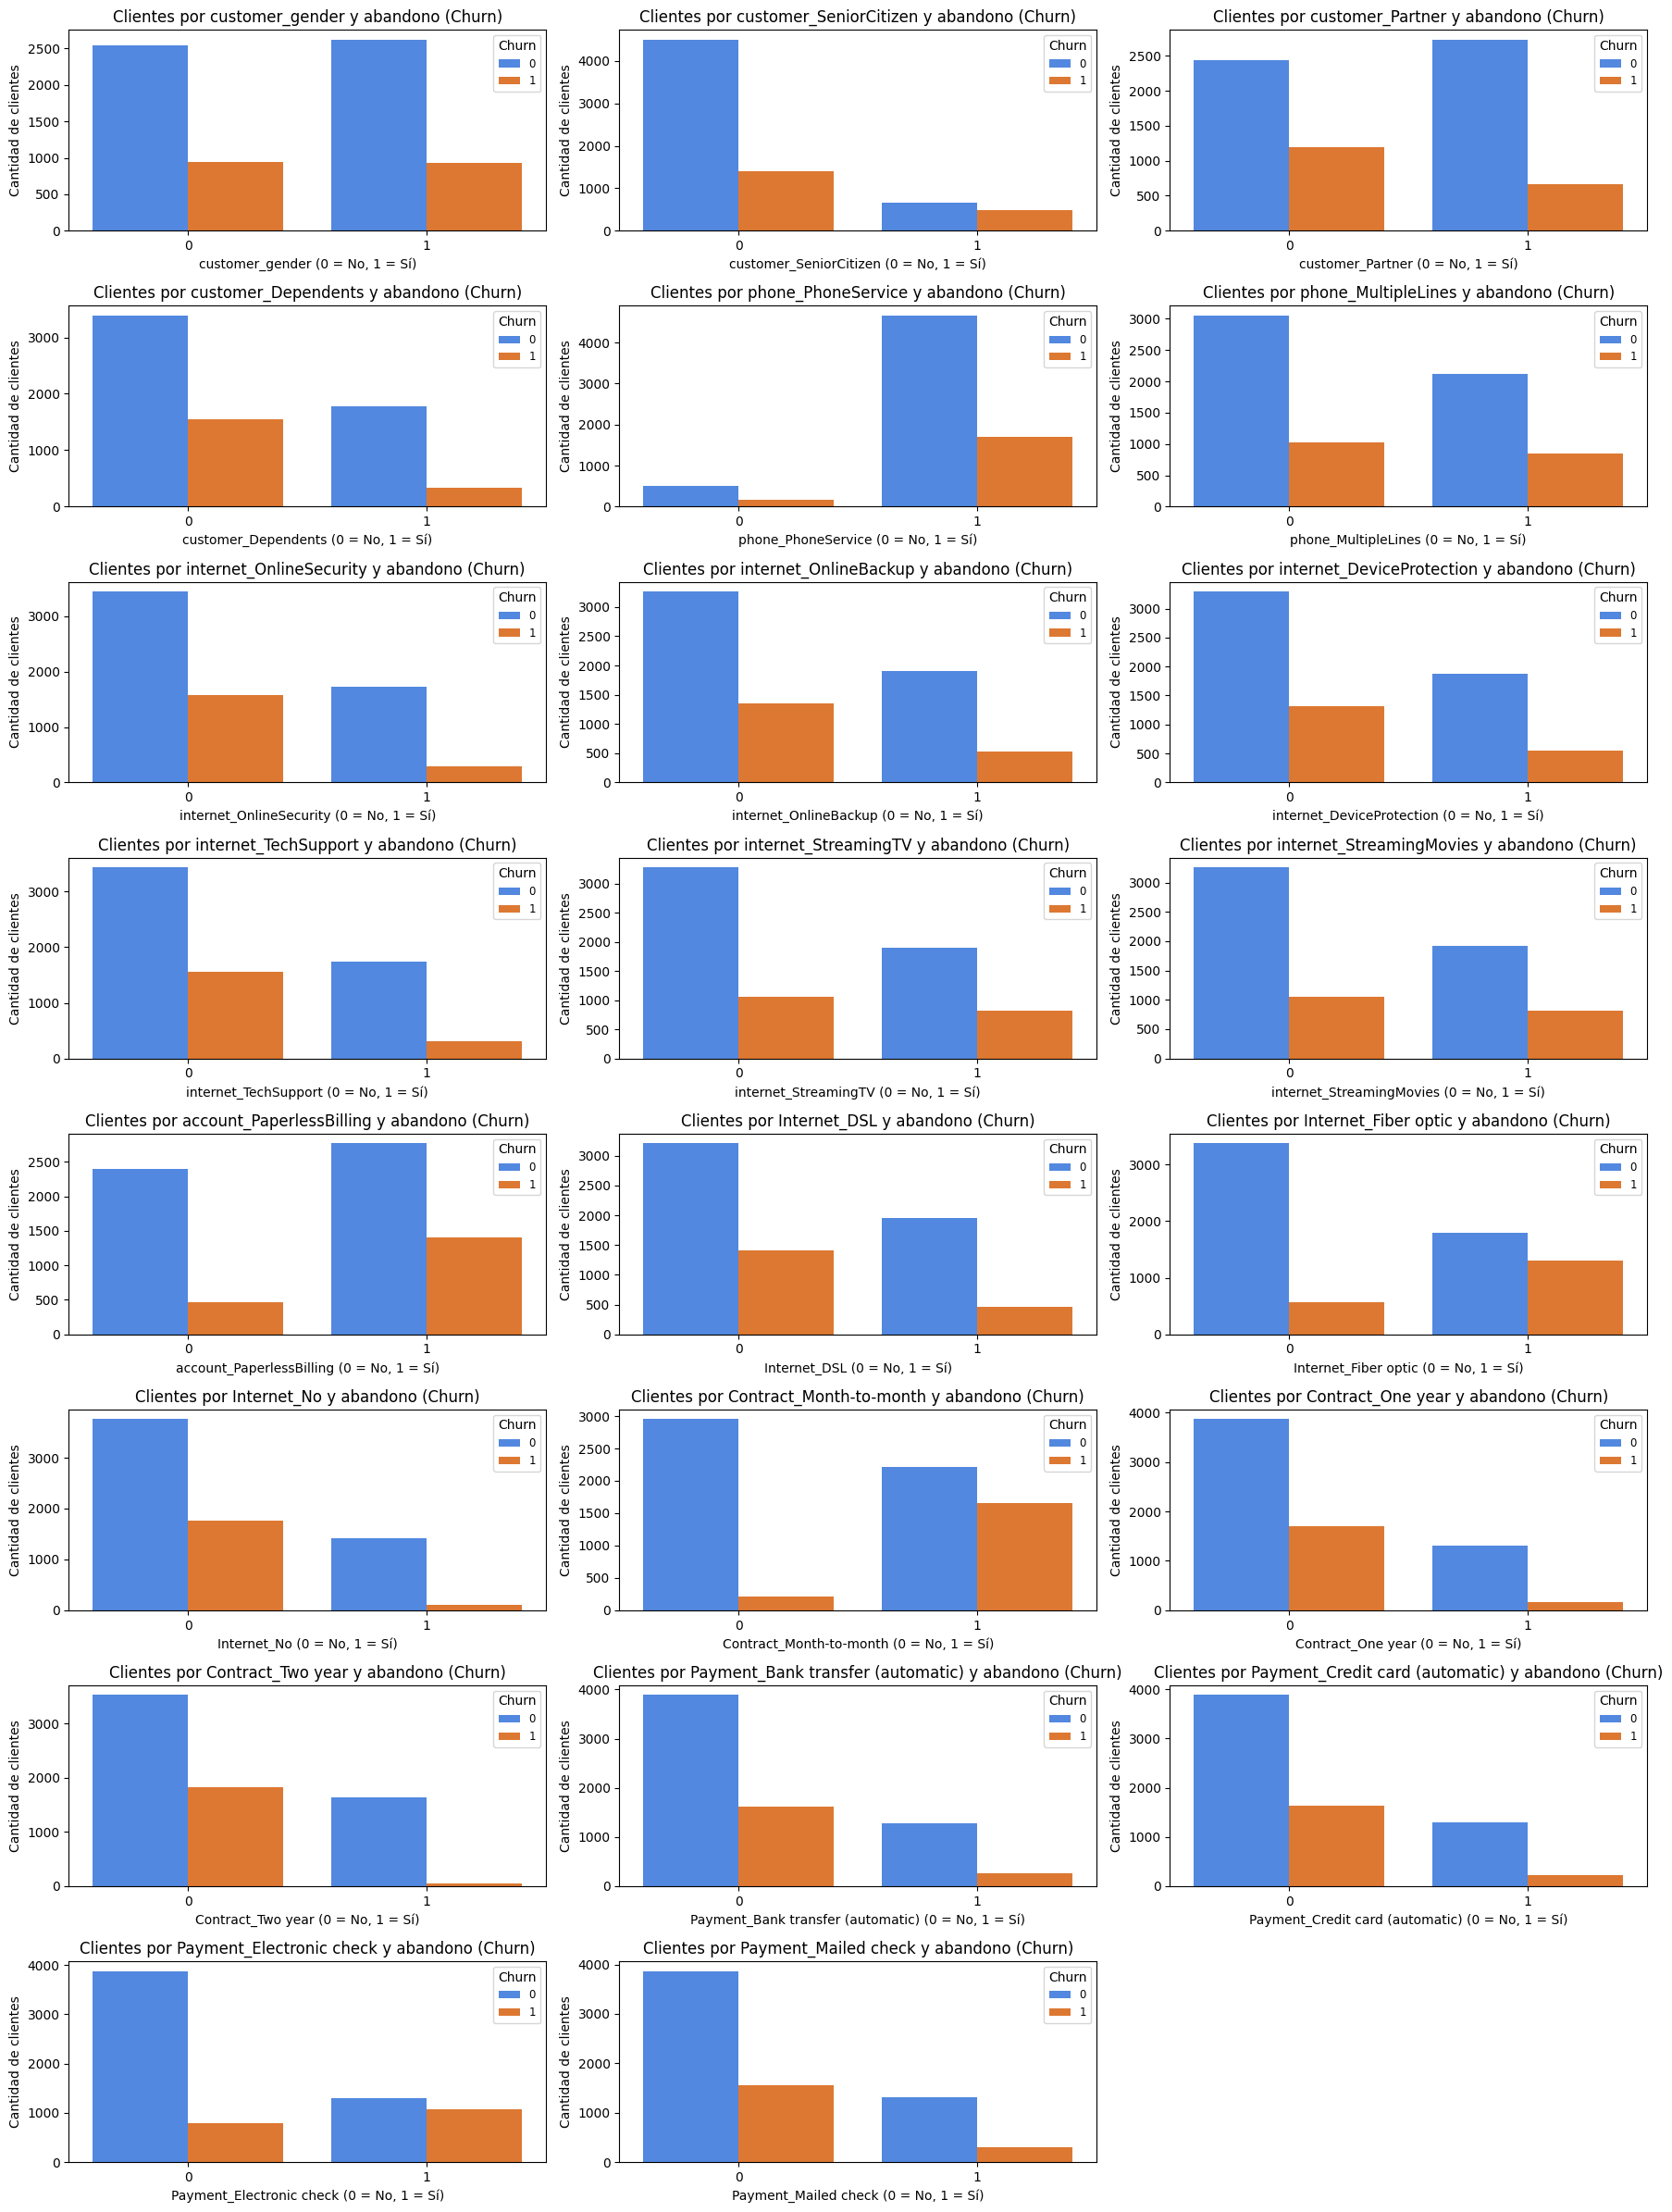

In [9]:
categoricas_binarias = [
    'customer_gender', 'customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents',
    'phone_PhoneService', 'phone_MultipleLines',
    'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection',
    'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies',
    'account_PaperlessBilling',
    'Internet_DSL', 'Internet_Fiber optic', 'Internet_No',
    'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
    'Payment_Bank transfer (automatic)', 'Payment_Credit card (automatic)',
    'Payment_Electronic check', 'Payment_Mailed check'
]

plt.figure(figsize=(18, 24))

for i, col in enumerate(categoricas_binarias):
    ax = plt.subplot(8, 3, i + 1)

    # Agrupamos por la variable y churn y contamos la cantidad
    counts = df.groupby([col, 'Churn']).size().reset_index(name='count')

    # Barplot agrupado con hue por Churn
    sns.barplot(data=counts, x=col, y='count', hue='Churn', palette=churn_palette, ax=ax)

    ax.set_title(f'Clientes por {col} y abandono (Churn)')
    ax.set_xlabel(f'{col} (0 = No, 1 = Sí)')
    ax.set_ylabel('Cantidad de clientes')
    ax.legend(title='Churn', fontsize='small', loc='upper right')

plt.tight_layout()
plt.show()


**Observaciones**

📊 1. **Características personales del cliente
Género (customer_gender)**:

No hay diferencias visibles entre hombres y mujeres en cuanto a abandono.

* Senior Citizen (customer_SeniorCitizen): Los ciudadanos mayores (1) tienen una mayor tasa de abandono que los no mayores (0).

* Pareja (customer_Partner): Los clientes con pareja (1) tienen menor proporción de abandono que los que no tienen (0).

* Dependientes (customer_Dependents): Los clientes con dependientes (1) también tienen menor tasa de abandono.

☎️ 2. **Servicios telefónicos
Phone Service (phone_PhoneService)**:

* Casi todos los clientes tienen servicio telefónico, y el abandono se distribuye dentro de ese grupo.

* Multiple Lines (phone_MultipleLines):Los clientes con múltiples líneas parecen abandonar ligeramente más que los que no tienen.

🌐 3. **Servicios de Internet
Online Security, Backup, Device Protection, Tech Support:**

* En todos estos casos, los clientes que no tienen estos servicios (0) abandonan más que los que sí los tienen (1). Sugiere que estos servicios tienen un efecto protector contra el abandono.

* StreamingTV y StreamingMovies: Los que usan estos servicios (1) parecen tener ligeramente más abandono, o al menos no hay un efecto protector claro.

💳 4. **Facturación y contrato
Facturación sin papel (PaperlessBilling):**

* Mayor abandono entre quienes tienen facturación electrónica (1).

* Tipo de contrato: Month-to-month (mensual): Mucho más abandono.

* One year / Two year: Menor tasa de abandono.Los contratos más largos retienen mejor a los clientes.

🧑‍💻 5. **Tipo de internet
DSL vs Fiber Optic vs No Internet:**

* Los usuarios de Fiber Optic tienen una tasa de abandono mucho mayor.

* Los que no tienen internet casi no abandonan (probablemente porque son usuarios de solo telefonía fija o muy básicos).

💰 6. **Método de pago
Electronic Check:**

* Claramente el método con mayor tasa de abandono.

* Bank transfer, Credit card (automático), Mailed check: Menor abandono en comparación con electronic check.

📌 **Conclusiones Generales**

1. Factores de riesgo de abandono:

* Clientes sin pareja, sin dependientes, ciudadanos mayores.

* Usuarios de contrato mensual y de pago por electronic check.

* Usuarios sin servicios de seguridad, respaldo, soporte técnico.

* Clientes con fiber optic y con facturación electrónica.

2. Factores protectores:

* Tener contrato anual o bianual.

* Tener servicios agregados de valor (backup, tech support).

* Uso de métodos de pago automáticos o tradicionales (menos abandono).

3. No discriminación por género:

* El género no parece influir en la tasa de abandono.

----

# 🔧**Preparación de los Datos**

## **Eliminación de Columnas Irrelevantes**

Se eliminan las columnas que no aportan valor al análisis o a los modelos predictivos, como identificadores únicos (por ejemplo, el ID del cliente). Estas columnas no ayudan en la predicción de la cancelación y pueden incluso perjudicar el desempeño de los modelos.

In [10]:
df = df.drop(columns=['customerID'])

## **Visualizacion de los datos**

In [11]:
#Visualizacion de los datos

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Churn                              7043 non-null   int64  
 1   customer_gender                    7043 non-null   int64  
 2   customer_SeniorCitizen             7043 non-null   int64  
 3   customer_Partner                   7043 non-null   int64  
 4   customer_Dependents                7043 non-null   int64  
 5   customer_tenure                    7043 non-null   int64  
 6   phone_PhoneService                 7043 non-null   int64  
 7   phone_MultipleLines                7043 non-null   int64  
 8   internet_OnlineSecurity            7043 non-null   int64  
 9   internet_OnlineBackup              7043 non-null   int64  
 10  internet_DeviceProtection          7043 non-null   int64  
 11  internet_TechSupport               7043 non-null   int64

## **Análisis de correlaciones**

* Detectar variables redundantes.

* Elegir las variables más relevantes.

* Evitar problemas como el sobreajuste o mala interpretación de los modelos.

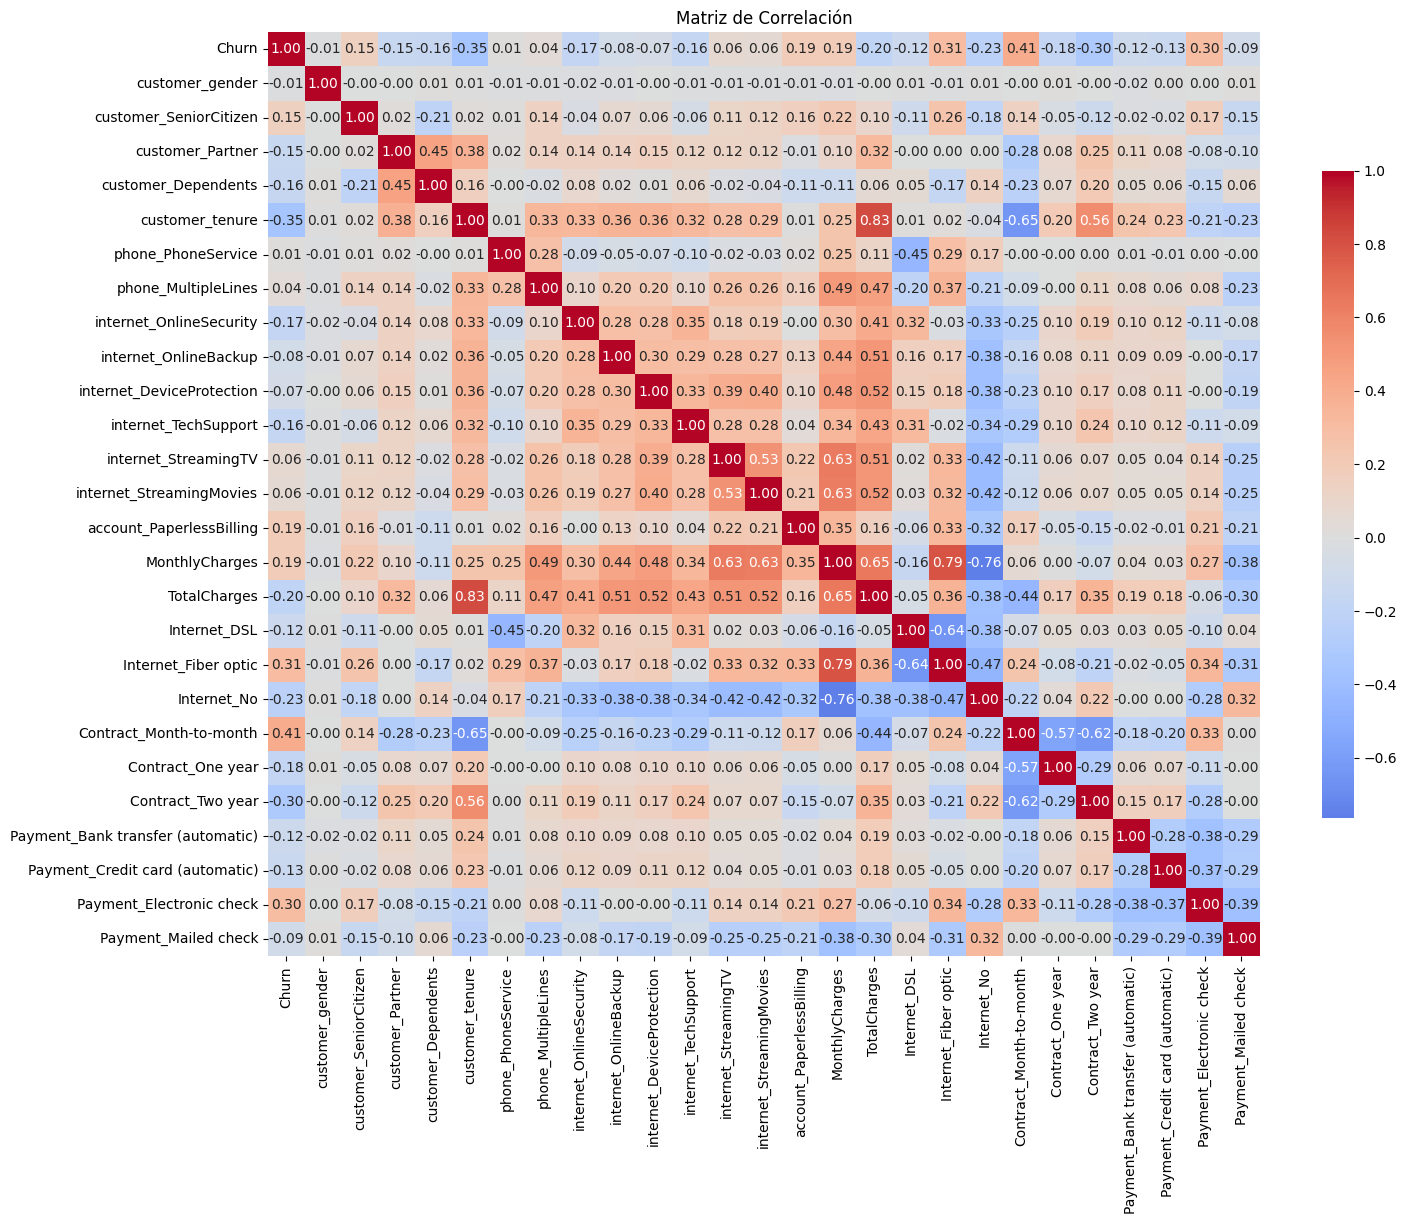

In [12]:
# Calculamos la matriz de correlación
correlation_matrix = df.corr(numeric_only=True)

# Tamaño del gráfico
plt.figure(figsize=(16, 12))

# Mapa de calor
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, cbar_kws={'shrink': 0.7})
plt.title("Matriz de Correlación")
plt.show()


In [13]:
# Correlación de todas las variables con la variable de salida Churn
correlation_with_churn = correlation_matrix['Churn'].sort_values(ascending=False)
print(correlation_with_churn)


Churn                                1.000000
Contract_Month-to-month              0.405103
Internet_Fiber optic                 0.308020
Payment_Electronic check             0.301919
MonthlyCharges                       0.193356
account_PaperlessBilling             0.191825
customer_SeniorCitizen               0.150889
internet_StreamingTV                 0.063228
internet_StreamingMovies             0.061382
phone_MultipleLines                  0.040102
phone_PhoneService                   0.011942
customer_gender                     -0.008612
internet_DeviceProtection           -0.066160
internet_OnlineBackup               -0.082255
Payment_Mailed check                -0.091683
Payment_Bank transfer (automatic)   -0.117937
Internet_DSL                        -0.124214
Payment_Credit card (automatic)     -0.134302
customer_Partner                    -0.150448
customer_Dependents                 -0.164221
internet_TechSupport                -0.164674
internet_OnlineSecurity           

**Observaciones clave del análisis de correlación con Churn**

Las correlaciones no son extremadamente altas (ninguna supera 0.5).

Hay patrones claros:

*  contractuales y de servicios tienen más impacto que características personales.

* Variables como tenure, tipo de contrato y servicios técnicos son buenos predictores de permanencia.

* Cargos altos y menor antigüedad tienden a indicar abandono.


🔴 **Variables más positivamente correlacionadas con abandono (Churn = 1):**

Estas variables aumentan la probabilidad de que un cliente se dé de baja:

| Variable                   | Correlación | Interpretación                                                                    |
| -------------------------- | ----------- | --------------------------------------------------------------------------------- |
| `Contract_Month-to-month`  | **+0.41**   | Los contratos mensuales tienen una alta tasa de abandono.                         |
| `Internet_Fiber optic`     | +0.31       | Los clientes con fibra óptica tienen mayor abandono, quizás por costos más altos. |
| `Payment_Electronic check` | +0.30       | Mayor abandono entre quienes pagan con cheque electrónico.                        |
| `MonthlyCharges`           | +0.19       | A mayor facturación mensual, mayor probabilidad de abandono.                      |
| `account_PaperlessBilling` | +0.19       | Ligeramente más abandono con facturación sin papel.                               |
| `customer_SeniorCitizen`   | +0.15       | Levemente mayor abandono entre adultos mayores.                                   |


🔵 **Variables negativamente correlacionadas con abandono:**

Estas variables se asocian con clientes que permanecen (Churn = 0):

| Variable                  | Correlación | Interpretación                                                          |
| ------------------------- | ----------- | ----------------------------------------------------------------------- |
| `customer_tenure`         | **-0.35**   | Cuanto más tiempo lleva el cliente, menor la probabilidad de abandono.  |
| `Contract_Two year`       | **-0.30**   | Contratos largos retienen más clientes.                                 |
| `Internet_No`             | -0.23       | Los clientes sin servicio de internet tienden a abandonar menos.        |
| `TotalCharges`            | -0.20       | Clientes con altos cargos totales suelen ser más estables.              |
| `Contract_One year`       | -0.18       | Contratos de un año también retienen más.                               |
| `internet_OnlineSecurity` | -0.17       | Servicios de seguridad en línea disminuyen la probabilidad de abandono. |
| `internet_TechSupport`    | -0.16       | El soporte técnico se asocia con mayor retención.                       |
| `customer_Dependents`     | -0.16       | Clientes con dependientes abandonan menos.                              |
| `customer_Partner`        | -0.15       | Tener pareja se asocia a menor abandono.                                |

-----

## **Normalización, Balanceo y Análisis de Correlaciones**

X_train y X_test son los datos originales sin escalar ni balancear.

X_train_scaled y X_test_scaled son los datos escalados.

X_train_resampled y y_train_resampled son los datos escalados y balanceados con SMOTE (solo para entrenamiento).

In [14]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

# 1. Separar features y target

X = df.drop(columns='Churn')  # Todas las columnas excepto la target
y = df['Churn']               # Columna objetivo

# 2. Separar datos en Train-Test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# 3. Escalado usando SOLO train para evitar data leakage
scaler = StandardScaler()
X_train_scaled_array = scaler.fit_transform(X_train)   # Ajusta y transforma train
X_test_scaled_array = scaler.transform(X_test)         # Transforma test con el mismo scaler

# 4. Convertir a DataFrame manteniendo nombres y índices originales
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X_test.columns, index=X_test.index)

# 5. Aplicar SMOTE SOLO sobre el train
smote = SMOTE(random_state=42)
X_train_resampled_array, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# 6. Convertir a DataFrame tras SMOTE
X_train_resampled = pd.DataFrame(X_train_resampled_array, columns=X_train.columns)

# 7. Garantizar que test tenga mismas columnas que train
X_test_scaled = X_test_scaled.reindex(columns=X_train.columns, fill_value=0)

# 8. Verificar distribución
print("Distribución original en train:", Counter(y_train))
print("Distribución después de SMOTE:", Counter(y_train_resampled))


Distribución original en train: Counter({0: 4139, 1: 1495})
Distribución después de SMOTE: Counter({0: 4139, 1: 4139})


**Observaciones**

1. Desbalance inicial significativo

* Clase 0 (clientes que no cancelaron): 4139 casos.

* Clase 1 (clientes que cancelaron): 1495 casos.

* Esto es aproximadamente 73% vs 27%, lo que confirma un desbalance importante que podría sesgar un modelo hacia predecir la clase mayoritaria.

2. SMOTE equilibró las clases en el conjunto de entrenamiento

* Después de aplicar SMOTE, ambas clases tienen 4139 ejemplos.

* Esto significa que se generaron 2644 muestras sintéticas para la clase minoritaria (Churn = 1).

3. Impacto esperado en el modelado

* El modelo ya no estará sesgado hacia la clase mayoritaria.

* Podrá aprender patrones de la clase minoritaria, pero hay que evaluar bien en el test set original para evitar un falso optimismo. Los datos de test deben quedar sin balancear, para reflejar la realidad.

------

## **Análisis de correlación sobre datos escalados y balanceados**

* Une datos balanceados y escalados en un DataFrame.

* Calcula y extrae correlaciones con la variable objetivo.

* Imprime las variables con mayor asociación positiva y negativa.

* Muestra la matriz de correlación completa en heatmap.

* *Presenta* un barplot con las correlaciones más relevantes.

In [15]:
# 1. Concatenar features y target balanceado para análisis conjunto
df_train_res = pd.concat([X_train_resampled, y_train_resampled.reset_index(drop=True)], axis=1)

# 2. Calcular matriz de correlación completa (features + target)
corr_matrix = df_train_res.corr()

# 3. Extraer correlaciones con 'Churn', ordenadas de mayor a menor
corr_with_churn = corr_matrix["Churn"].sort_values(ascending=False)

print("\nCorrelaciones con Churn (datos normalizados y balanceados):")
print(corr_with_churn)


Correlaciones con Churn (datos normalizados y balanceados):
Churn                                1.000000
Contract_Month-to-month              0.493358
Payment_Electronic check             0.335060
Internet_Fiber optic                 0.333165
account_PaperlessBilling             0.245242
MonthlyCharges                       0.207300
customer_SeniorCitizen               0.157438
internet_StreamingTV                 0.055859
internet_StreamingMovies             0.047214
phone_MultipleLines                  0.041002
phone_PhoneService                   0.002567
customer_gender                     -0.015160
Payment_Mailed check                -0.089495
internet_DeviceProtection           -0.094292
internet_OnlineBackup               -0.111449
Internet_DSL                        -0.133625
Payment_Bank transfer (automatic)   -0.161088
Payment_Credit card (automatic)     -0.167898
customer_Partner                    -0.205327
customer_Dependents                 -0.213333
internet_OnlineSecu

Variables con mayor correlación positiva con Churn:
 - Contract_Month-to-month: 0.493 (mayor probabilidad de abandono)
 - Payment_Electronic check: 0.335 (mayor probabilidad de abandono)
 - Internet_Fiber optic: 0.333 (mayor probabilidad de abandono)
 - account_PaperlessBilling: 0.245 (mayor probabilidad de abandono)
 - MonthlyCharges: 0.207 (mayor probabilidad de abandono)

Variables con mayor correlación negativa con Churn:
 - Contract_One year: -0.224 (menor probabilidad de abandono)
 - TotalCharges: -0.255 (menor probabilidad de abandono)
 - Internet_No: -0.280 (menor probabilidad de abandono)
 - Contract_Two year: -0.398 (menor probabilidad de abandono)
 - customer_tenure: -0.429 (menor probabilidad de abandono)


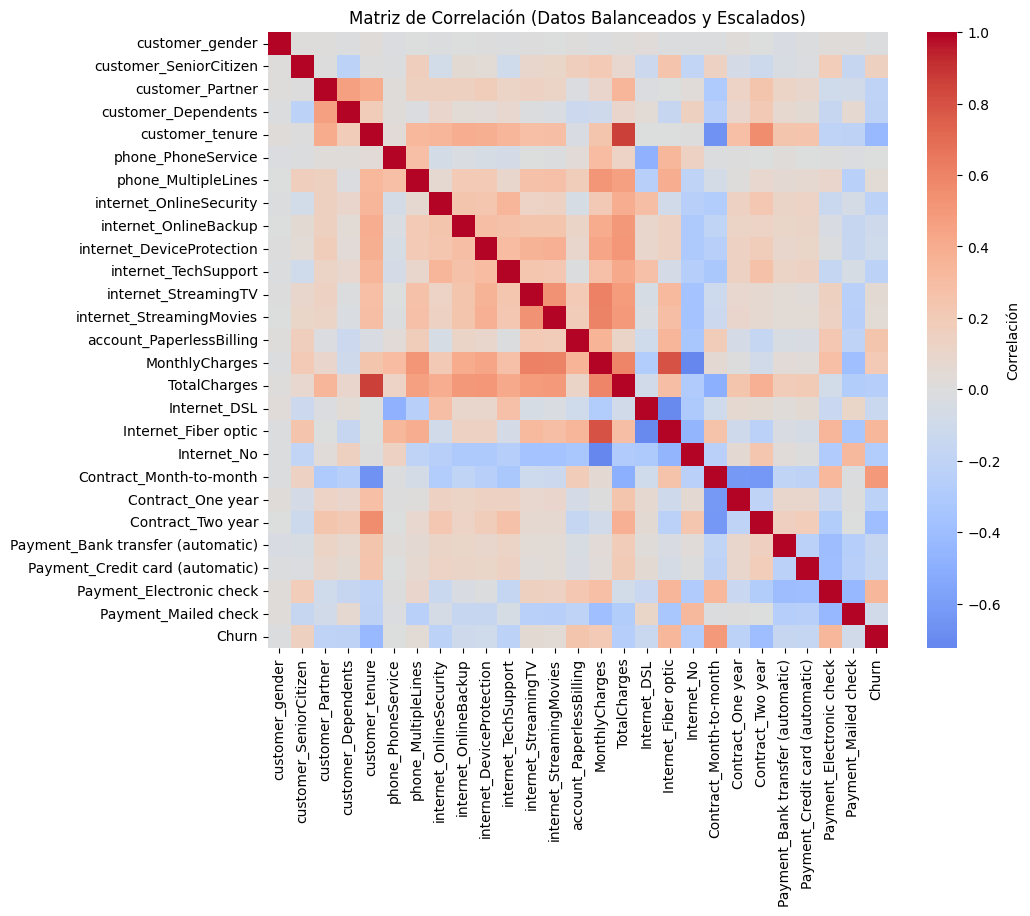

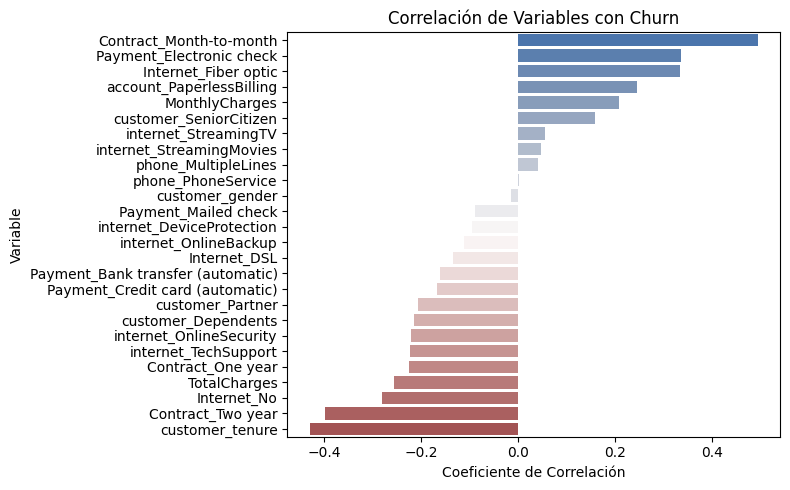

In [16]:
# 4. Mostrar variables con mayor correlación positiva y negativa con Churn
top_pos = corr_with_churn[1:6]  # Se saltea 'Churn' que tiene correlación 1 consigo misma
top_neg = corr_with_churn[-5:]

print("Variables con mayor correlación positiva con Churn:")
for var, val in top_pos.items():
    print(f" - {var}: {val:.3f} (mayor probabilidad de abandono)")

print("\nVariables con mayor correlación negativa con Churn:")
for var, val in top_neg.items():
    print(f" - {var}: {val:.3f} (menor probabilidad de abandono)")

# 5. Visualizar matriz de correlación completa con heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, cbar_kws={'label': 'Correlación'})
plt.title("Matriz de Correlación (Datos Balanceados y Escalados)")
plt.show()

# 6. Visualizar correlaciones con Churn en un barplot ordenado
plt.figure(figsize=(8, 5))
sns.barplot(x=corr_with_churn.values[1:], y=corr_with_churn.index[1:], palette="vlag")
plt.title("Correlación de Variables con Churn")
plt.xlabel("Coeficiente de Correlación")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


**Observación breve sobre correlaciones con Churn**

Variables como contratos mes a mes, pagos por cheque electrónico, fibra óptica, facturación sin papel y cargos mensuales altos se asocian a mayor abandono.

En cambio, contratos a uno o dos años, mayor antigüedad, gasto total alto y no tener internet están ligados a menor abandono y mayor fidelidad.

-----

# 💡**Modelado Predictivo**

Proceso de modelado para esos 5 modelos: Random Forest, XGBoost, Logistic Regression, LightGBM y KNN.


In [17]:
# opcional: silenciar warnings
import warnings
warnings.filterwarnings("ignore")

# básicos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# sklearn - modelado, métricas y utilidades
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

# modelos sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# modelos externos
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# imbalanced-learn (si usas SMOTE o imblearn pipeline)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

##  **Definir modelos, parámetros para tuning, entrenar pipeline y GridSearchCV**

In [18]:
# X_train_resampled, y_train_resampled, X_test_scaled, y_test

X_train = X_train_resampled
y_train = y_train_resampled
X_test = X_test_scaled

# Modelos
models = {
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=1000),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "KNN": KNeighborsClassifier()
}

# Parámetros para GridSearchCV
params = {
    "LogisticRegression": {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['liblinear']
    },
    "RandomForest": {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    "XGBoost": {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1]
    },
    "LightGBM": {
        'n_estimators': [100, 200],
        'max_depth': [-1, 10],
        'learning_rate': [0.01, 0.1]
    },
    "KNN": {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }
}

results = {}

# Entrenar y evaluar
for name in models:
    print(f"\nEntrenando {name}...")

    grid = GridSearchCV(
        estimator=models[name],
        param_grid=params[name],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)[:, 1]

    print(f"Mejores parámetros: {grid.best_params_}")
    print(f"ROC AUC test: {roc_auc_score(y_test, y_proba):.4f}")
    print(classification_report(y_test, y_pred))

    results[name] = {
        'model': grid.best_estimator_,
        'best_params': grid.best_params_,
        'roc_auc': roc_auc_score(y_test, y_proba),
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }

# Tabla comparativa de métricas
metrics_list = []
for name, res in results.items():
    cr = res['classification_report']
    metrics_list.append({
        'Model': name,
        'ROC_AUC': res['roc_auc'],
        'Accuracy': cr['accuracy'],
        'Precision_1': cr['1']['precision'],
        'Recall_1': cr['1']['recall'],
        'F1_1': cr['1']['f1-score']
    })

metrics_df = pd.DataFrame(metrics_list)
print(metrics_df.sort_values(by='ROC_AUC', ascending=False))


Entrenando LogisticRegression...
Mejores parámetros: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
ROC AUC test: 0.8423
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1035
           1       0.52      0.79      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409


Entrenando RandomForest...
Mejores parámetros: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
ROC AUC test: 0.8278
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      1035
           1       0.59      0.61      0.60       374

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.73      1409
weighted avg       0.79      0.78      0.78      1409


Entrenando XGBoost...
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 6, 'n_esti

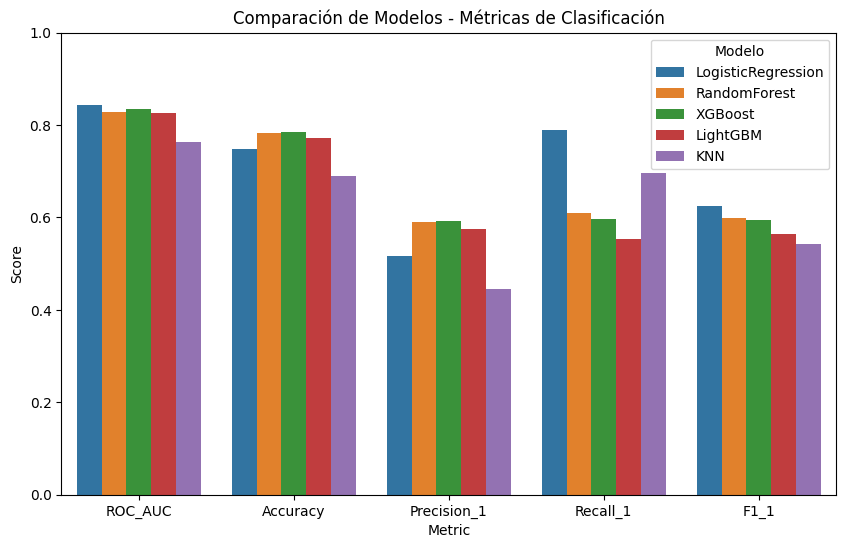

In [19]:
# Gráfico comparativo
df_melted_new = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted_new, x="Metric", y="Score", hue="Model")
plt.title("Comparación de Modelos - Métricas de Clasificación")
plt.ylim(0, 1)
plt.legend(title="Modelo")
plt.show()

## **Feature Importance y gráficos**

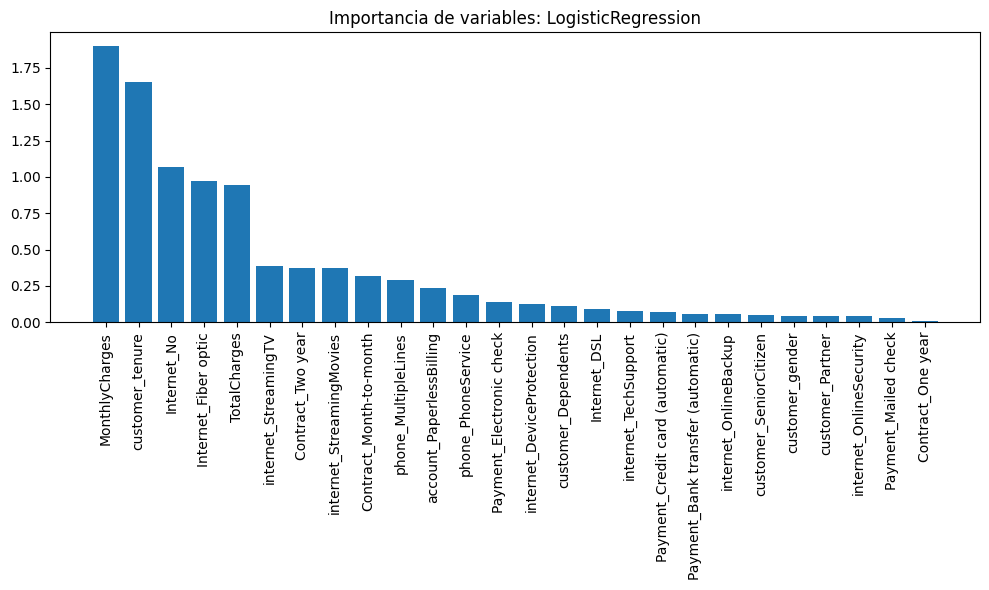

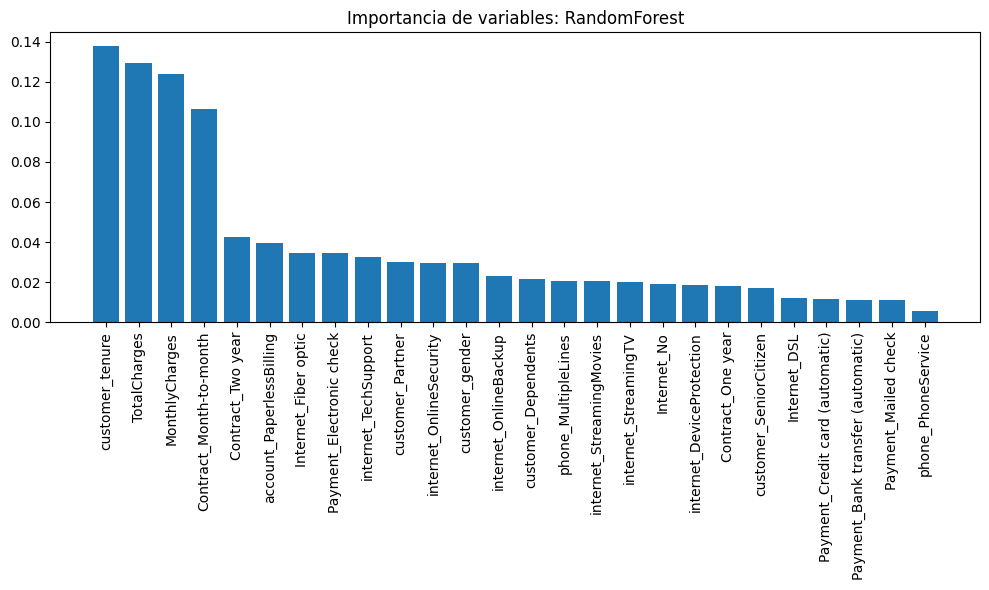

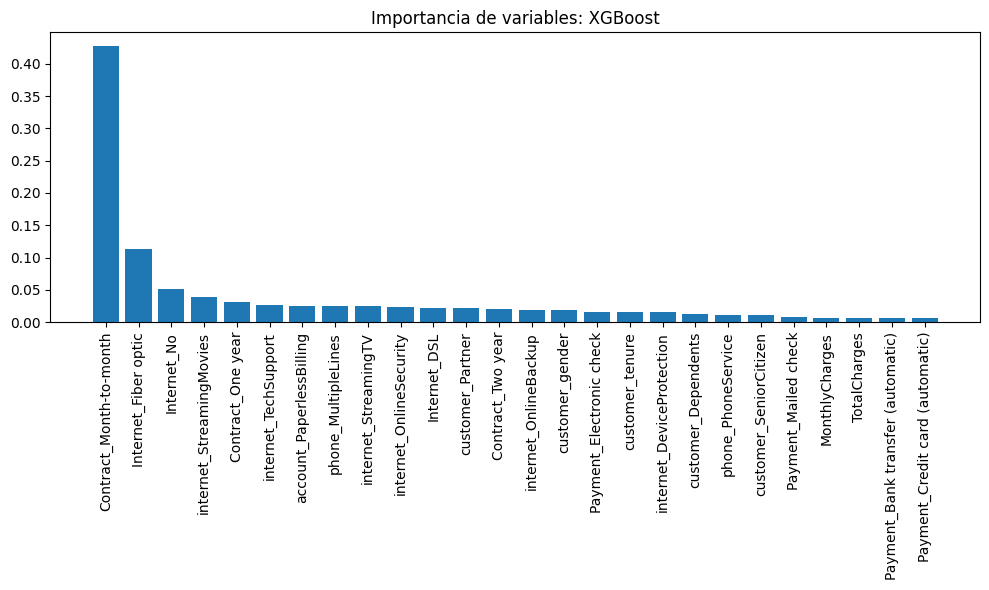

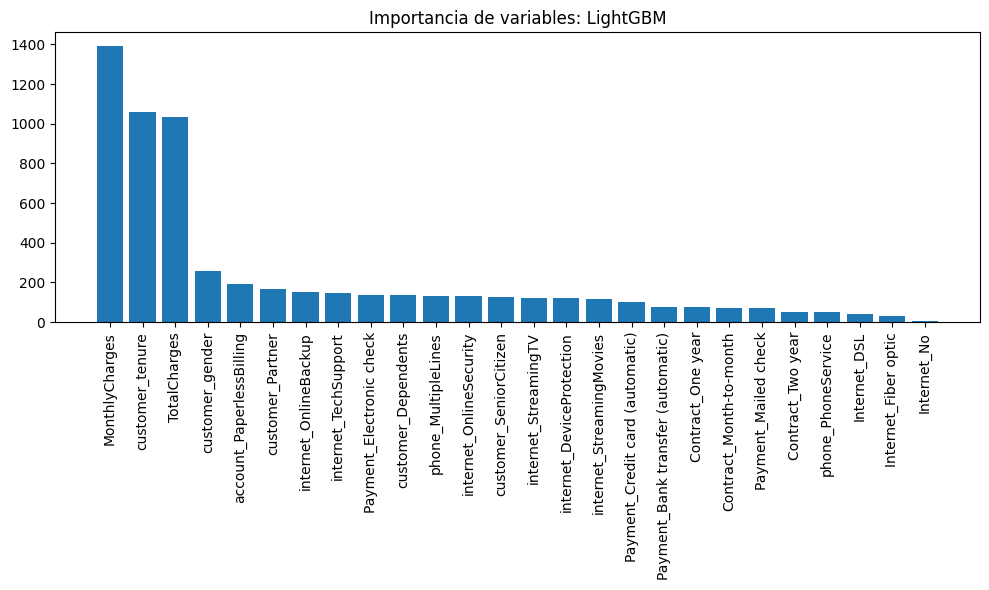

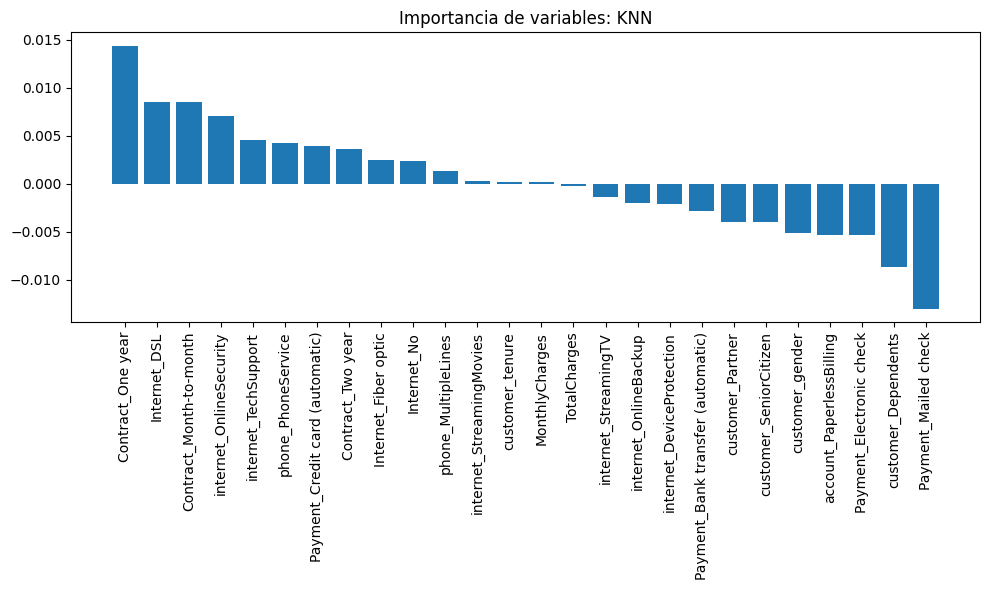

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

def plot_feature_importance(model, X, y, model_name):
    plt.figure(figsize=(10,6))

    if hasattr(model, 'named_steps'):
        model_step = list(model.named_steps.values())[-1]
    else:
        model_step = model  # Es un modelo puro, no un pipeline

    # Determinar importancia según tipo de modelo
    if hasattr(model_step, 'feature_importances_'):
        importances = model_step.feature_importances_
    elif hasattr(model_step, 'coef_'):
        importances = np.abs(model_step.coef_[0])
    elif model_name == 'KNN':
        r = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
        importances = r.importances_mean
    else:
        print(f"Modelo '{model_name}' no soporta importancia de variables.")
        return

    # Ordenar e imprimir
    indices = np.argsort(importances)[::-1]
    features = X.columns

    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), features[indices], rotation=90)
    plt.title(f'Importancia de variables: {model_name}')
    plt.tight_layout()
    plt.show()


# Ejecutar
for name, res in results.items():
    plot_feature_importance(res['model'], X_test, y_test, name)



## **Comparar métricas en tabla**

                Model   ROC_AUC  Accuracy  Precision_1  Recall_1      F1_1
0  LogisticRegression  0.842340  0.748048     0.516637  0.788770  0.624339
2             XGBoost  0.833986  0.784244     0.593085  0.596257  0.594667
1        RandomForest  0.827761  0.783534     0.589147  0.609626  0.599212
3            LightGBM  0.825141  0.772889     0.575000  0.553476  0.564033
4                 KNN  0.762918  0.689851     0.445969  0.695187  0.543365


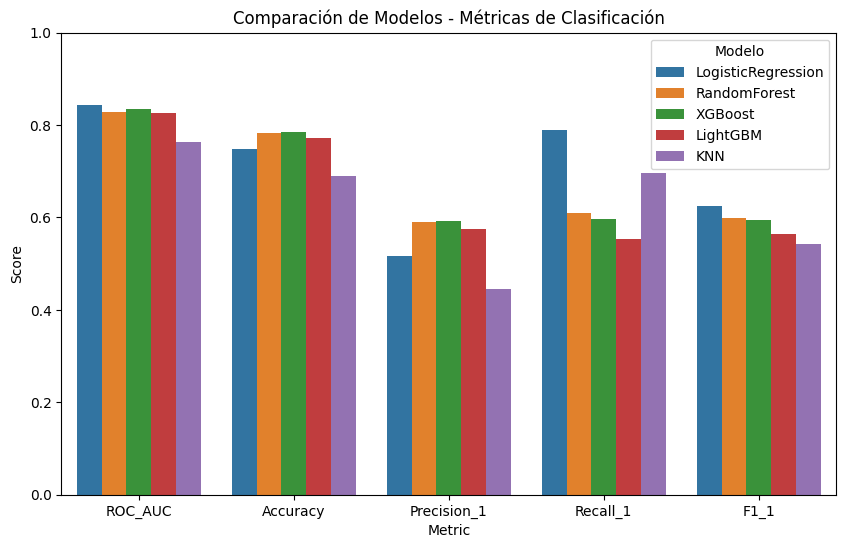

In [21]:
from sklearn.metrics import classification_report, roc_auc_score

metrics_list = [] # Inicialización de lista vacia

for name, res in results.items():
    cr = res['classification_report']
    metrics_list.append({
        'Model': name,
        'ROC_AUC': res['roc_auc'],
        'Accuracy': cr['accuracy'],
        'Precision_1': cr['1']['precision'],
        'Recall_1': cr['1']['recall'],
        'F1_1': cr['1']['f1-score']
    })

# DataFrame de la lista de diccionarios
metrics_df = pd.DataFrame(metrics_list)

print(metrics_df.sort_values(by='ROC_AUC', ascending=False))

# Gráficos
df_melted_new = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted_new, x="Metric", y="Score", hue="Model")
plt.title("Comparación de Modelos - Métricas de Clasificación")
plt.ylim(0, 1)
plt.legend(title="Modelo")
plt.show()

**Observaciones**

* Logistic Regression tiene el mejor recall, lo que indica que detecta más casos reales de abandono, aunque su precisión es más baja. Esto implica que es un modelo que prioriza no perder casos positivos, pero podría generar más falsos positivos. Ideal si quieres captar la mayor cantidad posible de abandonos.

* XGBoost y Random Forest tienen un rendimiento muy similar en ROC AUC y métricas balanceadas. Ambas son buenas opciones si buscas un equilibrio entre precisión y recall. Son modelos más complejos que Logistic Regression, y en este caso, no superan ampliamente a la regresión logística en recall.

* LightGBM tiene métricas un poco más bajas que XGBoost y Random Forest, pero sigue siendo competitivo y puede ser útil si buscas rapidez y eficiencia.

* KNN es el modelo con peor desempeño, especialmente en precisión y ROC AUC. Esto podría deberse a que el modelo no maneja bien la complejidad o el desequilibrio del dataset.


| Modelo             | ROC\_AUC | Accuracy | Precision | Recall | F1 Score | Comentario                    |
| ------------------ | -------- | -------- | --------- | ------ | -------- | ----------------------------- |
| LogisticRegression | 0.8423   | 0.7480   | 0.5166    | 0.7888 | 0.6243   | 🔝 Mejor recall, buen balance |
| XGBoost            | 0.8340   | 0.7842   | 0.5931    | 0.5963 | 0.5947   | ⚡ Buen rendimiento general    |
| RandomForest       | 0.8279   | 0.7842   | 0.5907    | 0.6096 | 0.6000   | 🌲 Estable y consistente      |
| LightGBM           | 0.8251   | 0.7729   | 0.5750    | 0.5535 | 0.5640   | 💡 Ligero pero efectivo       |
| KNN                | 0.7629   | 0.6899   | 0.4460    | 0.6952 | 0.5434   | 🐢 Más lento y menos preciso  |


📌 Conclusión general

🔝 Logistic Regression: mejor para detectar abandonos, puede dar falsos positivos.

⚡ XGBoost y Random Forest: buen balance y potencia para modelos no lineales.

💡 LightGBM: opción rápida y eficiente, aunque con un pequeño sacrificio en métricas.

🐢 KNN: menos recomendable para este problema.

**Nota:**

* Si la prioridad es capturar la mayor cantidad de abandonos (alto recall), Logistic Regression es la mejor opción.

* Si se quiere un modelo con mejor equilibrio entre precisión y recall, XGBoost o Random Forest pueden ser preferibles.

* El F1 score refleja el balance entre precisión y recall, y Random Forest tiene el valor más alto, seguido de XGBoost, que indica que estos modelos hacen un buen trade-off.


------

## **Análisis técnico de las matrices de confusión**

Matriz de confusión — Logistic Regression:
[[759 276]
 [ 79 295]] 

Matriz de confusión — Random Forest:
[[876 159]
 [146 228]] 

Matriz de confusión — XGBoost:
[[882 153]
 [151 223]] 

Matriz de confusión — LightGBM:
[[882 153]
 [167 207]] 

Matriz de confusión — KNN:
[[712 323]
 [114 260]] 



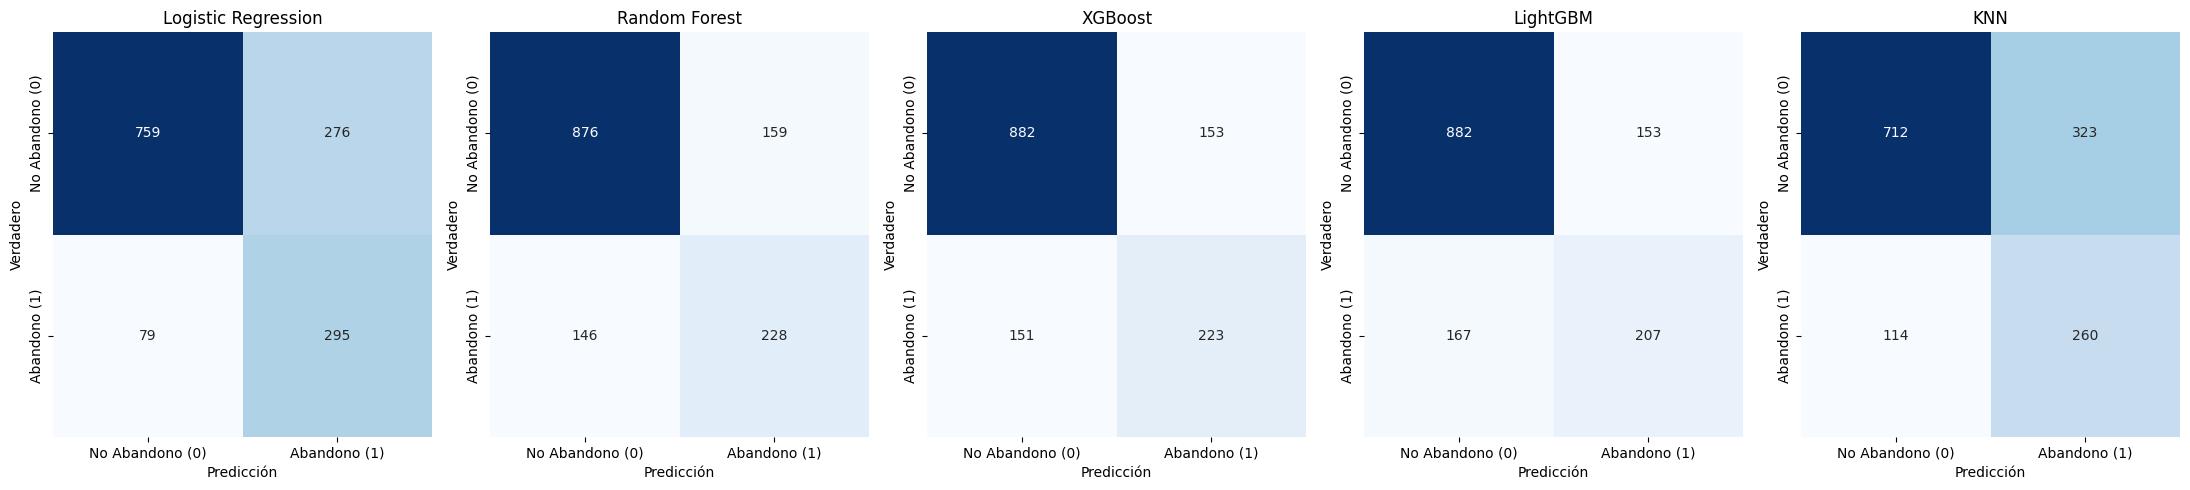

                Modelo  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.748048   0.516637  0.788770  0.624339
1        Random Forest  0.783534   0.589147  0.609626  0.599212
2              XGBoost  0.784244   0.593085  0.596257  0.594667
3             LightGBM  0.772889   0.575000  0.553476  0.564033
4                  KNN  0.689851   0.445969  0.695187  0.543365


In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

model_dict = {
    "Logistic Regression": results["LogisticRegression"]["model"],
    "Random Forest": results["RandomForest"]["model"],
    "XGBoost": results["XGBoost"]["model"],
    "LightGBM": results["LightGBM"]["model"],
    "KNN": results["KNN"]["model"]
}


fig, axes = plt.subplots(1, len(model_dict), figsize=(22, 5))

results_list = []

for ax, (name, model) in zip(axes, model_dict.items()):

    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Matriz de confusión — {name}:")
    print(cm, "\n")

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(name)
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Verdadero')
    ax.set_xticks([0.5, 1.5])
    ax.set_yticks([0.5, 1.5])
    ax.set_xticklabels(['No Abandono (0)', 'Abandono (1)'])
    ax.set_yticklabels(['No Abandono (0)', 'Abandono (1)'])

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results_list.append([name, acc, prec, rec, f1])

plt.tight_layout()
plt.show()

df_results = pd.DataFrame(results_list, columns=['Modelo', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
print(df_results)


**Observaciones**

* TN (Verdaderos Negativos): Casos correctamente clasificados como no abandono.

* FP (Falsos Positivos): Casos incorrectamente clasificados como abandono (falsos alarmas).

* FN (Falsos Negativos): Casos incorrectamente clasificados como no abandono (abandono no detectado).

* TP (Verdaderos Positivos): Casos correctamente clasificados como abandono.

| Modelo              | TN  | FP  | FN  | TP  | Observaciones 📝                                                                  |
| ------------------- | ------------------------------ | ---------------------- | ---------------------------- | --------------------------- | --------------------------------------------------------------------------------- |
| Logistic Regression | 759                            | 276                    | 79                           | 295                         | 🔍 Mejor para detectar abandonos (menos ❌) pero más falsas alarmas (🚨)           |
| Random Forest       | 876                            | 159                    | 146                          | 228                         | 🌳 Mejor para evitar falsas alarmas (menos 🚨), pero pierde más abandonos (❌)     |
| XGBoost             | 882                            | 153                    | 151                          | 223                         | ⚡ Similar a RF, buen control de falsas alarmas, pero más abandonos no detectados  |
| LightGBM            | 882                            | 153                    | 167                          | 207                         | 🍃 Más conservador, muchas menos falsas alarmas, pero más abandonos no detectados |
| KNN                 | 712                            | 323                    | 114                          | 260                         | 👟 Peor balance, muchas falsas alarmas y abandonos perdidos                       |


* Logistic Regression tiene el menor FN, es decir, detecta mejor a los que realmente abandonan (menos abandonos no detectados), pero a costa de más FP.

* Random Forest y XGBoost tienen mayor TN (más casos negativos bien identificados) y menos FP que Logistic Regression, pero tienen más FN, por lo que pierden más abandonos.

* LightGBM pierde aún más abandonos y mantiene TN alto.

* KNN tiene peor balance, con muchos FP y FN.

👉 En resumen:

* Si el objetivo es minimizar la pérdida real de clientes (falsos negativos bajos), Logistic Regression es mejor.

* Si se busca minimizar el costo por falsas alarmas (falsos positivos bajos), XGBoost o Random Forest son mejores.

-------

# 🚀**Mejora de modelos**

* Se prioriza tuning para LightGBM y Random Forest para mejorar recall sin sacrificar demasiado precisión.

* Se revisa y optimiza Logistic Regression para balancear mejor recall y precisión.

* Se evalúa si vale la pena mantener KNN o descartarlo según desempeño.

---------
### **Pasos generales para cada modelo (KNN, LightGBM, Random Forest, Logistic Regression, XGBoost):**

**1. Preparación de datos**

* Escalar variables con StandardScaler usando solo el conjunto de entrenamiento.

* Aplicar SMOTE para balancear las clases en entrenamiento.

* Transformar el conjunto de test con el mismo scaler (sin SMOTE).

**2. Construcción de pipeline**

* Crear un Pipeline que incluya scaler, SMOTE y el modelo.

* Permite que el preprocesamiento esté integrado en la validación cruzada y entrenamiento.

**3. Tuning de hiperparámetros**

* Usar GridSearchCV con métrica ROC AUC para buscar los parámetros óptimos.

* Validación cruzada para evitar overfitting.

**4. Evaluación en test**

* Predecir probabilidades y clases con el mejor modelo.

* Calcular métricas: accuracy, precision, recall, f1-score, ROC AUC.

* Generar reporte de clasificación.

* Calcular y graficar matriz de confusión.

* Graficar curva ROC individual.

**5. Comparación global**

* Superponer todas las curvas ROC en un solo gráfico para comparar modelos.

**6. Guardado del modelo**

* Guardar el modelo entrenado y sus parámetros para uso futuro.

------


## **Definición de Modelos, parámetros para mejorarlos, entrenamiento y evaluación**

In [23]:
# ======================
# IMPORTS
# ======================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, roc_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# ======================
# 1. SPLIT DE DATOS CRUDOS
# ======================
X = df.drop(columns='Churn')
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ======================
# 2. DEFINICIÓN DE MODELOS Y PARÁMETROS
# ======================
model_params = {
    "LogisticRegression": {
        "model": LogisticRegression(random_state=42, max_iter=1000),
        "params": {
            'model__C': [0.1, 1, 10],
            'model__penalty': ['l2'],
            'model__solver': ['liblinear']
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            'model__n_estimators': [100, 200],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "params": {
            'model__n_estimators': [100, 200],
            'model__max_depth': [3, 6],
            'model__learning_rate': [0.01, 0.1]
        }
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42),
        "params": {
            'model__n_estimators': [100, 200],
            'model__max_depth': [-1, 10],
            'model__learning_rate': [0.01, 0.1]
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            'model__n_neighbors': [3, 5, 7, 9],
            'model__weights': ['uniform', 'distance'],
            'model__metric': ['euclidean', 'manhattan']
        }
    }
}

# ======================
# 3. ENTRENAMIENTO Y EVALUACIÓN
# ======================
results = []

for name, mp in model_params.items():
    print(f"\n🔹 Entrenando {name}...")

    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('model', mp["model"])
    ])

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=mp["params"],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    y_prob = grid.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(f"Mejores parámetros: {grid.best_params_}")
    print(f"ROC AUC test: {roc_auc:.4f}")
    print(classification_report(y_test, y_pred))

    results.append({
        'Model': name,
        'ROC_AUC': roc_auc,
        'Accuracy': acc,
        'Precision_1': prec,
        'Recall_1': rec,
        'F1_1': f1,
        'model': grid.best_estimator_,   # Modelo pipeline entrenado
        'y_pred': y_pred,                # Predicciones en test
        'y_prob': y_prob                 # Probabilidades en test
    })

    joblib.dump(grid.best_estimator_, f"{name}_best_model.pkl")


🔹 Entrenando LogisticRegression...
Mejores parámetros: {'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
ROC AUC test: 0.8425
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409


🔹 Entrenando RandomForest...
Mejores parámetros: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 200}
ROC AUC test: 0.8411
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1035
           1       0.56      0.72      0.63       374

    accuracy                           0.78      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.78      0.78      1409


🔹 Entrenando XGBoost...
Mejores parámetros:


📊 Comparativa de modelos:
                Model   ROC_AUC  Accuracy  Precision_1  Recall_1      F1_1  \
2             XGBoost  0.845455  0.782825     0.574561  0.700535  0.631325   
3            LightGBM  0.843091  0.774308     0.559574  0.703209  0.623223   
0  LogisticRegression  0.842511  0.743790     0.511304  0.786096  0.619600   
1        RandomForest  0.841062  0.775727     0.560166  0.721925  0.630841   
4                 KNN  0.794007  0.713982     0.474606  0.724599  0.573545   

                                               model  \
2  (StandardScaler(), SMOTE(random_state=42), XGB...   
3  (StandardScaler(), SMOTE(random_state=42), LGB...   
0  (StandardScaler(), SMOTE(random_state=42), Log...   
1  (StandardScaler(), SMOTE(random_state=42), (De...   
4  (StandardScaler(), SMOTE(random_state=42), KNe...   

                                              y_pred  \
2  [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...   
3  [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...   

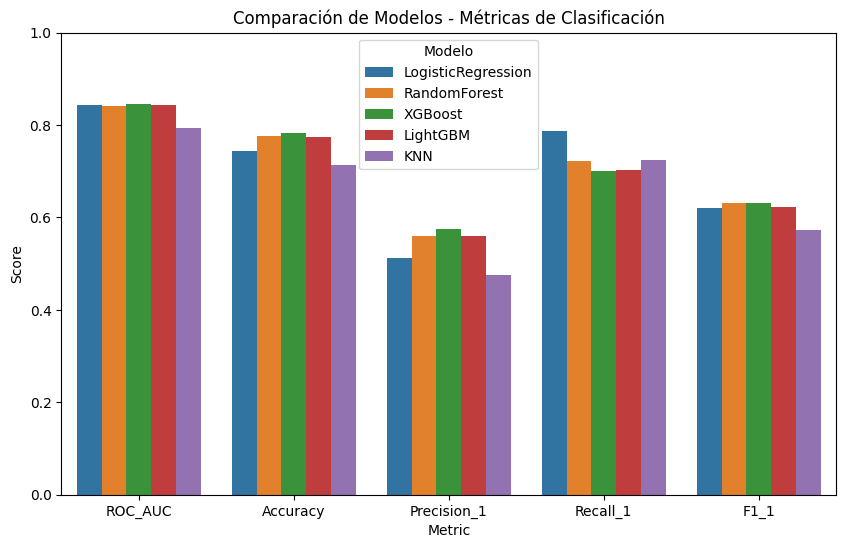

In [27]:
# ======================
# 4. TABLA COMPARATIVA
# ======================
metrics_df = pd.DataFrame(results)
print("\n📊 Comparativa de modelos:")
print(metrics_df.sort_values(by='ROC_AUC', ascending=False))

# ======================
# 5. GRÁFICO DE MÉTRICAS
# ======================
metrics_to_plot = ['Model', 'ROC_AUC', 'Accuracy', 'Precision_1', 'Recall_1', 'F1_1']

metrics_df_filtered = metrics_df[metrics_to_plot]

df_melted = metrics_df_filtered.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x="Metric", y="Score", hue="Model")
plt.title("Comparación de Modelos - Métricas de Clasificación")
plt.ylim(0, 1)
plt.legend(title="Modelo")
plt.show()



Matriz de Confusión - LogisticRegression:
[[754 281]
 [ 80 294]]


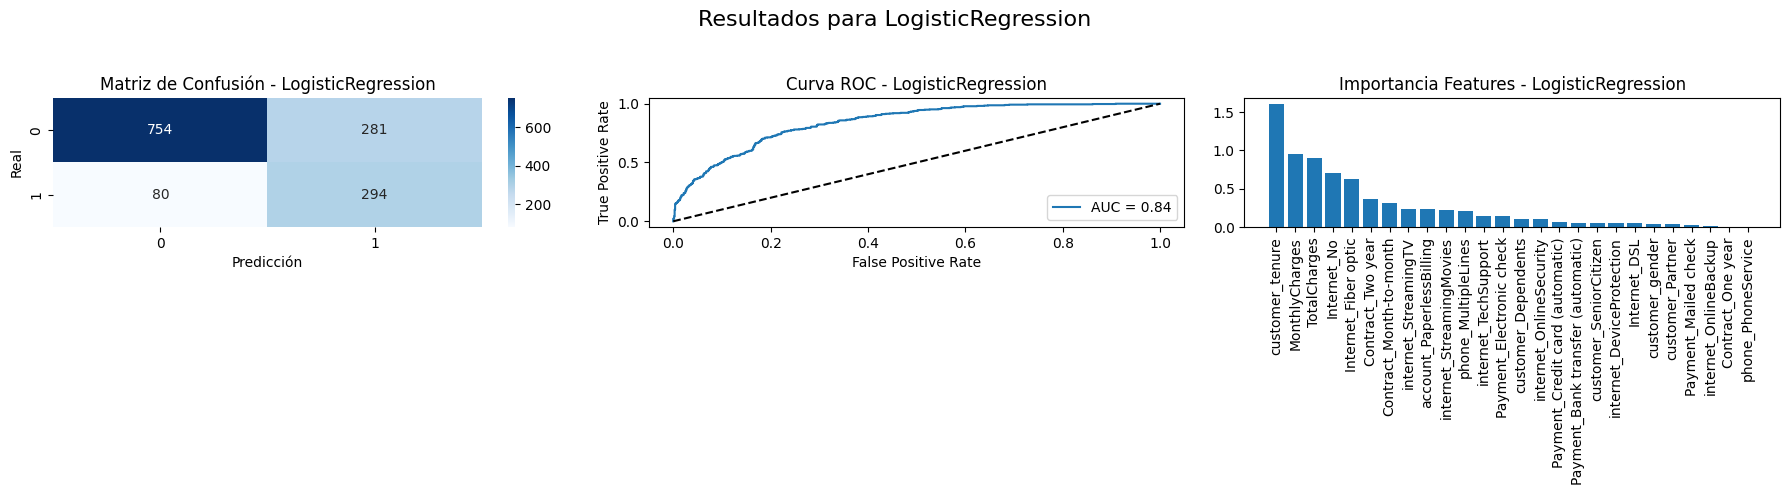


Matriz de Confusión - RandomForest:
[[823 212]
 [104 270]]


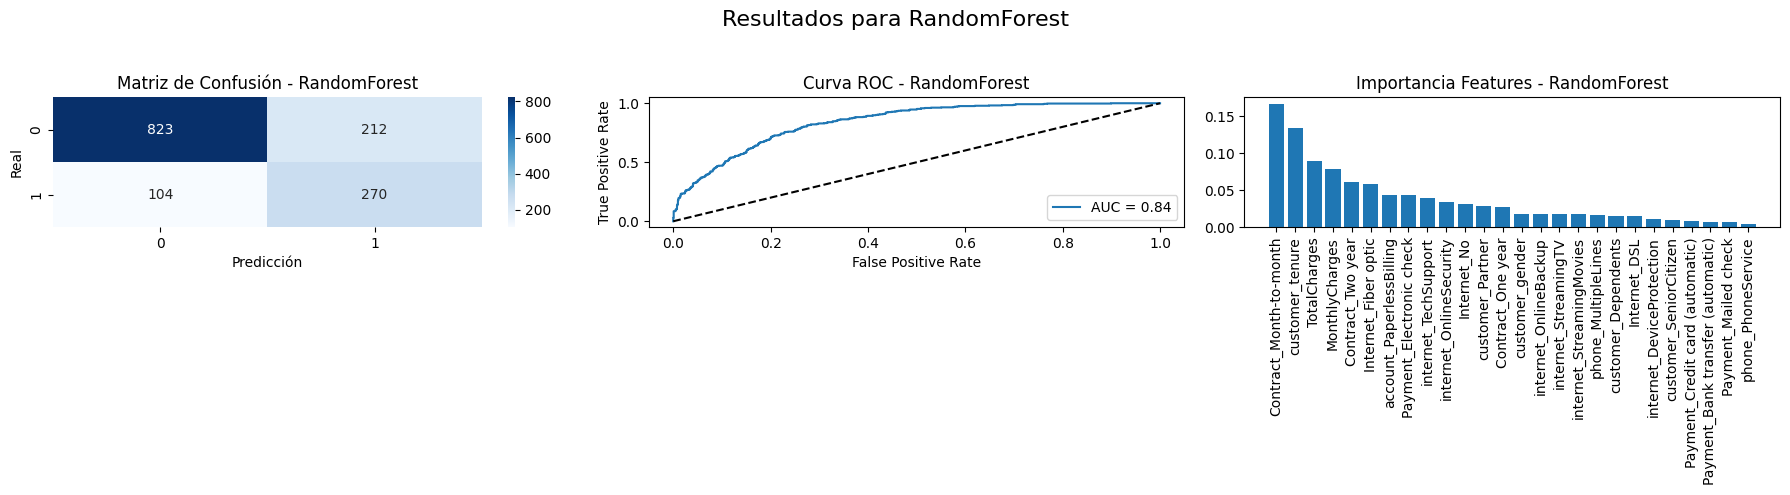


Matriz de Confusión - XGBoost:
[[841 194]
 [112 262]]


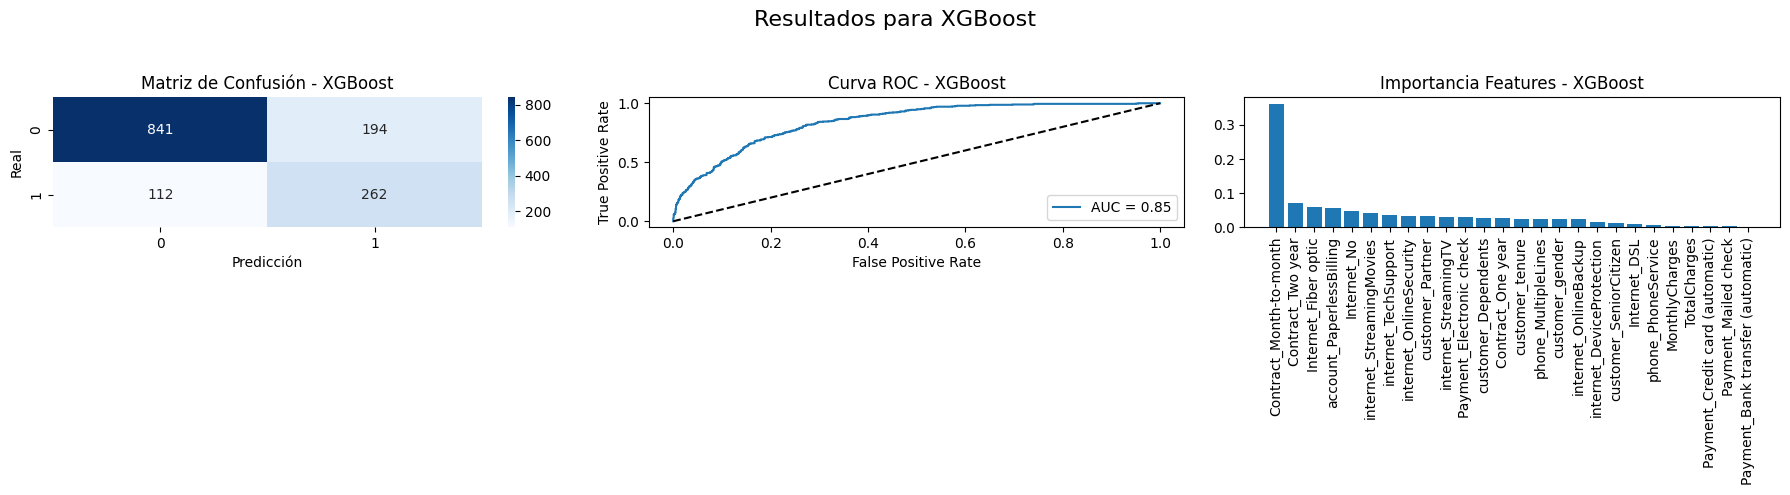


Matriz de Confusión - LightGBM:
[[828 207]
 [111 263]]


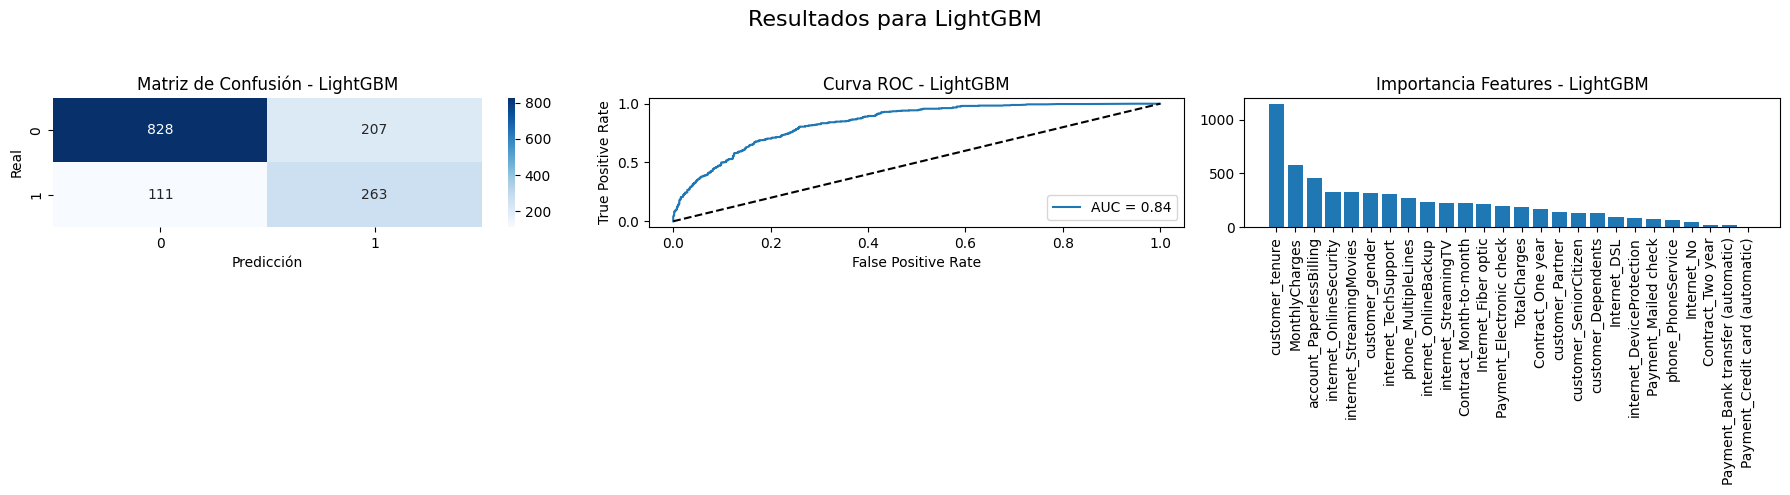


Matriz de Confusión - KNN:
[[735 300]
 [103 271]]


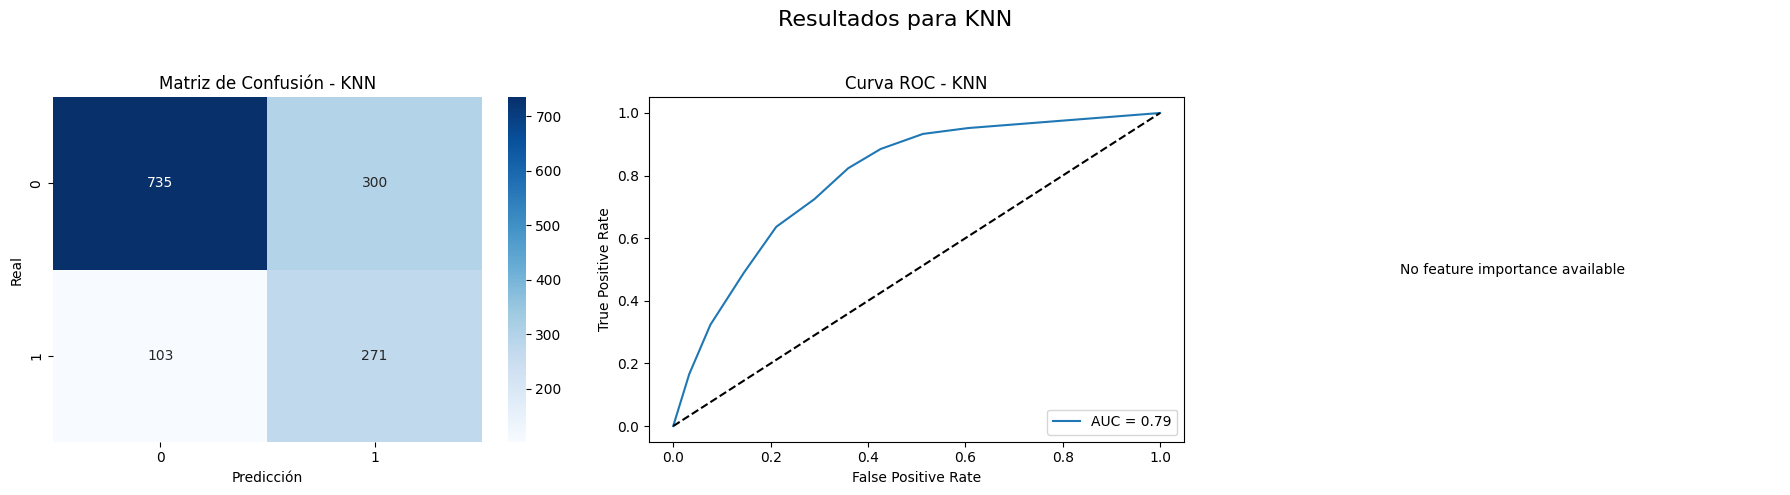

In [28]:
# ======================
# 6. GRÁFICOS Y ANÁLISIS
# ======================
from sklearn.metrics import auc

# --- Funciones para graficar ---
def plot_confusion_matrix_ax(y_true, y_pred, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')

def plot_roc_curve_ax(y_true, y_prob, ax, title):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc_val = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'AUC = {roc_auc_val:.2f}')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_title(title)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')

def plot_feature_importance_ax(model, feature_names, ax, title):
    # Accedemos al modelo interno del pipeline
    clf = model.named_steps['model']

    if hasattr(clf, "feature_importances_"):
        importances = clf.feature_importances_
    elif hasattr(clf, "coef_"):
        importances = np.abs(clf.coef_[0])
    else:
        ax.text(0.5, 0.5, "No feature importance available", ha='center', va='center')
        ax.axis('off')
        return

    indices = np.argsort(importances)[::-1]
    ax.bar(range(len(importances)), importances[indices])
    ax.set_xticks(range(len(importances)))
    ax.set_xticklabels(feature_names[indices], rotation=90)
    ax.set_title(title)

# --- Graficar ---
roc_curves = {}

for res in results:
    name = res['Model']
    model = res['model']
    y_pred = res['y_pred']
    y_prob = res['y_prob']

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    plt.suptitle(f"Resultados para {name}", fontsize=16)

    # Imprimir matriz de confusión en consola
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nMatriz de Confusión - {name}:")
    print(cm)

    plot_confusion_matrix_ax(y_test, y_pred, axes[0], f"Matriz de Confusión - {name}")
    plot_roc_curve_ax(y_test, y_prob, axes[1], f"Curva ROC - {name}")
    plot_feature_importance_ax(model, X.columns, axes[2], f"Importancia Features - {name}")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Guardar datos para comparación global ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc_val = auc(fpr, tpr)
    roc_curves[name] = (fpr, tpr, roc_auc_val)


# ⚖️**Modelo seleccionado**

## **Comparativa de los Modelos mejorados**

Se usan las siguientes leyendas:

✅ Bueno / Estable / Destacado

🔼 Alto / Mejora

🔽 Bajo / Puede mejorar


### **Comparación por Métricas**

| Modelo                 | ROC AUC  | Accuracy | Precision | Recall   | F1 Score | Observación breve                                                         |
| ---------------------- | -------- | -------- | --------- | -------- | -------- | ------------------------------------------------------------------------- |
| **XGBoost**            | 0.845 ✅  | 0.783 ✅  | 0.575 ✅   | 0.701 ✅  | 0.631 ✅  | 🚀 Mejor ROC AUC y buen equilibrio precisión-recall. Gran opción general. |
| **LightGBM**           | 0.843 ✅  | 0.774 ✅  | 0.560 ✅   | 0.703 ✅  | 0.623 ✅  | ⚡ Similar a XGBoost, buen recall para captar abandonos.                   |
| **LogisticRegression** | 0.843 ✅  | 0.744 🔽 | 0.511 🔽  | 0.786 🔼 | 0.620 ✅  | 🔍 Alto recall, detecta más abandonos, pero menor precisión.              |
| **RandomForest**       | 0.841 ✅  | 0.776 ✅  | 0.560 ✅   | 0.722 ✅  | 0.631 ✅  | 🌳 Balance sólido, muy competitivo con XGBoost y LightGBM.                |
| **KNN**                | 0.794 🔽 | 0.714 🔽 | 0.475 🔽  | 0.725 ✅  | 0.574 🔽 | 🐢 Menor rendimiento general, puede ser descartado para producción.       |




**Observaciones**

✅ XGBoost tiene el mejor balance en recall y F1 Score.

🔼 Regresión Logística destaca en recall, aunque su precision es menor.

🔽 KNN tiene la precisión más baja, pero un recall aceptable.

🟡 Random Forest y LightGBM tienen métricas similares, pero con menor recall y F1 comparado con XGBoost.

-----

### **Comparación por matriz de confusión**

| Modelo                 | TN  | FP  | FN  | TP  | Observaciones                                                                 |
| ---------------------- | --- | --- | --- | --- | ----------------------------------------------------------------------------- |
| **KNN**                | 735 | 300 | 103 | 271 | 🔼 Buen Recall (TP alto) <br> 🔽 Muchos Falsos Positivos (FP altos)           |
| **LightGBM**           | 828 | 207 | 111 | 263 | ✅ Buen equilibrio <br> 🔽 Algo más FN que KNN, pero menos FP                  |
| **XGBoost**            | 841 | 194 | 112 | 262 | ✅ Mejor TN (FP bajo) <br> 🔽 FN similar a LightGBM                            |
| **RandomForest**       | 823 | 212 | 104 | 270 | ✅ Balanceado <br> 🔼 FN ligeramente mejor que XGBoost                         |
| **LogisticRegression** | 754 | 281 | 80  | 294 | ✅ Mejor FN (menos falsos negativos) <br> 🔼 Más FP (riesgo de costos mayores) |

**Observaciones**

* Logistic Regression tiene la menor cantidad de falsos negativos, ideal si queremos asegurar detectar la mayor cantidad de clientes que van a abandonar (minimizar pérdidas), aunque aumenta falsos positivos (posible costo adicional). ✅🔼

* XGBoost y RandomForest ofrecen un buen balance entre TN y FN, con menor FP que Logistic Regression. ✅

* KNN tiene más falsos positivos, lo que puede generar alertas innecesarias. 🔽

* LightGBM también es bastante equilibrado, pero con un poco más de falsos negativos que Logistic Regression. 🔽

------

## **Creación de Modelo Ensamble**

El modelo de ensamble es tipo stacking con XGBoost + Random Forest + Logistic Regression.

Se elige opción de combinación Stacking(apilamiento).

Nota: Combinar modelos (ensembles) puede mejorar la robustez y la precisión general al aprovechar fortalezas distintas de cada modelo y compensar sus debilidades.

Reporte clasificación - Stacking (XGB + RF + LR):
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1035
           1       0.58      0.62      0.60       374

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.72      1409
weighted avg       0.78      0.78      0.78      1409

Matriz de Confusión:
[[863 172]
 [141 233]]


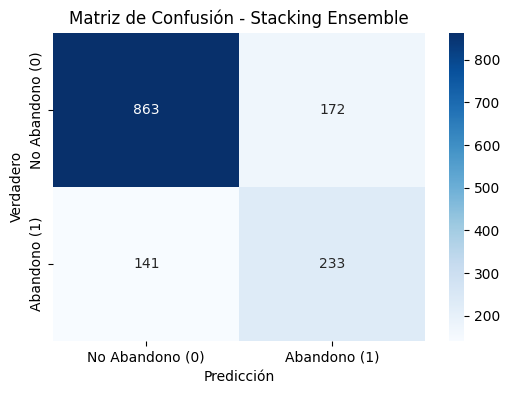

ROC AUC: 0.8341


In [29]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# 1. Definir base models con parámetros ya ajustados
estimators = [
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
]

# 2. Definir stacking con LR como meta-modelo
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=42),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# 3. Pipeline con SMOTE + Escalado + Stacking
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('stacking', stacking_clf)
])

# 4. Entrenar pipeline completo
pipeline.fit(X_train, y_train)

# 5. Predecir con pipeline (usa escalado y stacking juntos)
y_pred_stacking = pipeline.predict(X_test)
y_prob_stacking = pipeline.predict_proba(X_test)[:,1]

# 6. Métricas y reporte (coherentes y sin confusiones)
print("Reporte clasificación - Stacking (XGB + RF + LR):")
print(classification_report(y_test, y_pred_stacking))

cm = confusion_matrix(y_test, y_pred_stacking)
print("Matriz de Confusión:")
print(cm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Abandono (0)', 'Abandono (1)'],
            yticklabels=['No Abandono (0)', 'Abandono (1)'])
plt.title('Matriz de Confusión - Stacking Ensemble')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

roc_auc = roc_auc_score(y_test, y_prob_stacking)
print(f"ROC AUC: {roc_auc:.4f}")

acc = accuracy_score(y_test, y_pred_stacking)
prec = precision_score(y_test, y_pred_stacking)
rec = recall_score(y_test, y_pred_stacking)
f1 = f1_score(y_test, y_pred_stacking)

results.append({
    'Model': 'Stacking Ensemble',
    'ROC_AUC': roc_auc,
    'Accuracy': acc,
    'Precision_1': prec,
    'Recall_1': rec,
    'F1_1': f1,
    'model': pipeline,
    'y_pred': y_pred_stacking,
    'y_prob': y_prob_stacking
})


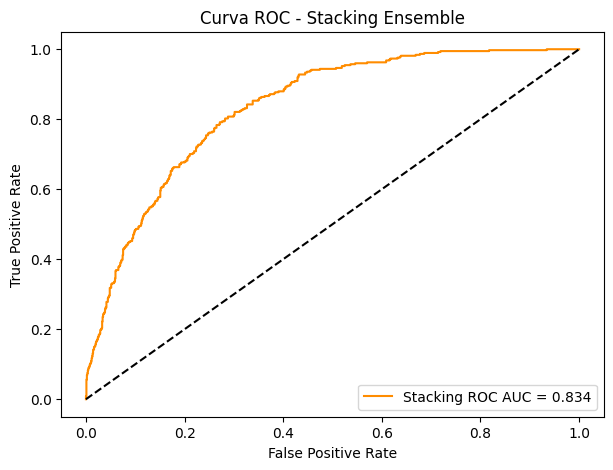

['stacking_pipeline.pkl']

In [30]:
# 7.Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_stacking)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'Stacking ROC AUC = {roc_auc:.3f}', color='darkorange')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Stacking Ensemble')
plt.legend(loc='lower right')
plt.show()

# 8. Guardar pipeline completo (incluye SMOTE y scaler)
joblib.dump(pipeline, "stacking_pipeline.pkl")

**Observaciones del modelo Stacking**

* El ensamble mejora la estabilidad general combinando la fuerza de XGBoost, Random Forest y Regresión Logística.

* Detecta razonablemente bien los clientes que abandonan (recall 62%), pero con cierta tasa de falsos positivos (precisión 58%).

* Puede ser buena opción si se prioriza un balance entre minimizar pérdidas por abandono y evitar gastos excesivos en clientes mal clasificados.

* Para mejorar, podrías explorar ajustar umbrales de decisión o estrategias de costo-beneficio específicas según el negocio.

## 🏆**Elección del Modelo**

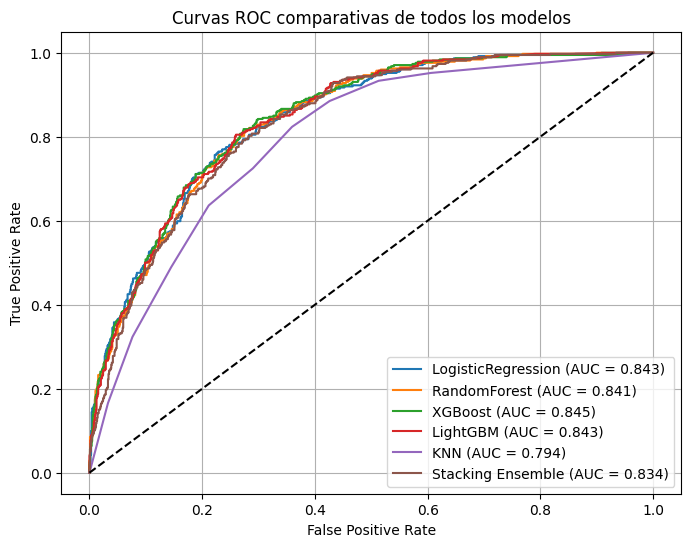

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score,
    precision_recall_curve, average_precision_score
)

summary = []
plt.figure(figsize=(8,6))

# 1. Curvas ROC
for res in results:
    name = res['Model']
    y_pred = res['y_pred']
    y_prob = res['y_prob']

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_val = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    ap = average_precision_score(y_test, y_prob)

    summary.append([name, acc, prec, rec, f1, auc_val, ap])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_val:.3f})')

plt.plot([0,1], [0,1], 'k--')
plt.title('Curvas ROC comparativas de todos los modelos')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


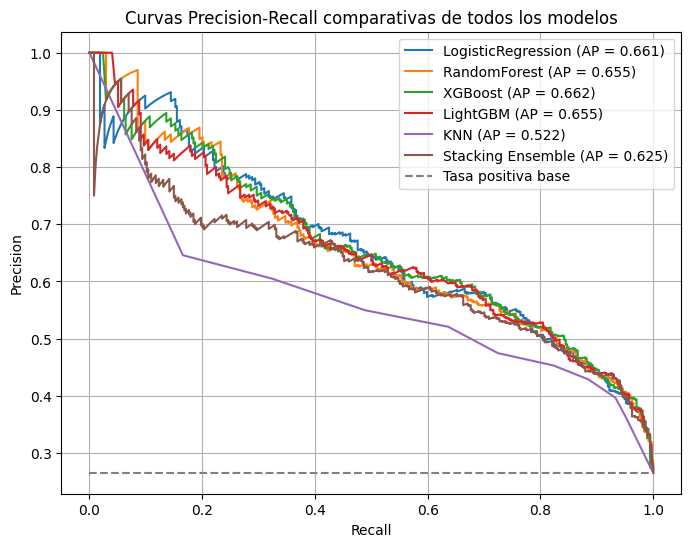

In [39]:
# 2. Curvas Precision-Recall
plt.figure(figsize=(8,6))
for res in results:
    name = res['Model']
    y_prob = res['y_prob']
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    plt.plot(recall, precision, label=f'{name} (AP = {ap:.3f})')

positive_rate = y_test.mean()
plt.hlines(positive_rate, 0, 1, colors='gray', linestyles='--', label='Tasa positiva base')
plt.title('Curvas Precision-Recall comparativas de todos los modelos')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

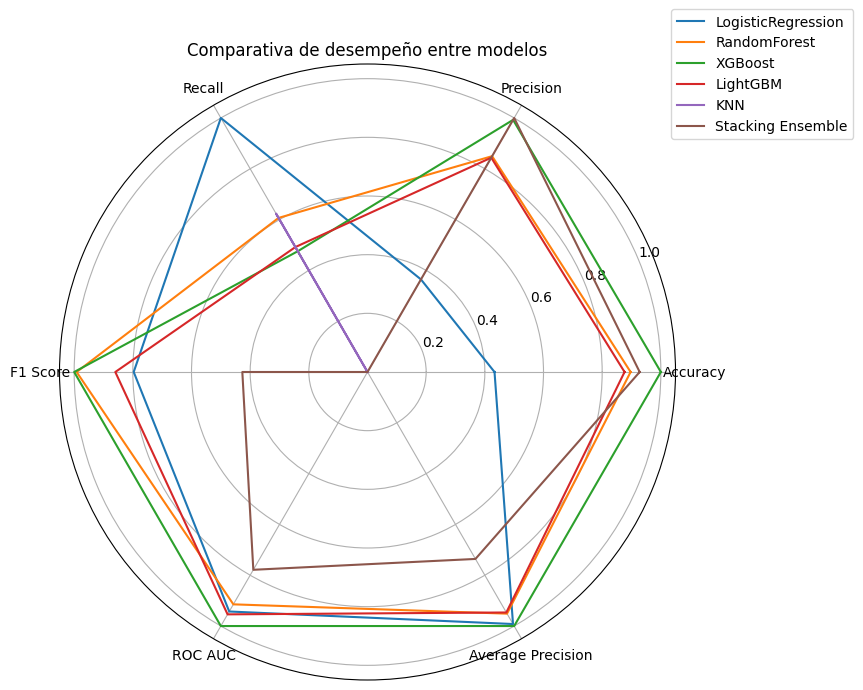

Resumen de métricas por modelo:
               Modelo  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
2             XGBoost  0.782825   0.574561  0.700535  0.631325  0.845455   
0  LogisticRegression  0.743790   0.511304  0.786096  0.619600  0.842511   
1        RandomForest  0.775727   0.560166  0.721925  0.630841  0.841062   
3            LightGBM  0.774308   0.559574  0.703209  0.623223  0.843091   
5   Stacking Ensemble  0.777857   0.575309  0.622995  0.598203  0.834063   
4                 KNN  0.713982   0.474606  0.724599  0.573545  0.794007   

   Average Precision  
2           0.662018  
0           0.660913  
1           0.655186  
3           0.654540  
5           0.625009  
4           0.521887  


In [40]:
#  3. Radar Chart
df_summary = pd.DataFrame(summary, columns=['Modelo', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Average Precision'])

# Normalizar métricas para radar
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Average Precision']
df_norm = df_summary.copy()
for col in metrics:
    df_norm[col] = (df_norm[col] - df_norm[col].min()) / (df_norm[col].max() - df_norm[col].min())

angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(8,8))
for i, row in df_norm.iterrows():
    values = row[metrics].tolist()
    values += values[:1]
    plt.polar(angles, values, label=row['Modelo'])
plt.xticks(angles[:-1], metrics)
plt.title('Comparativa de desempeño entre modelos')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


print("Resumen de métricas por modelo:")
print(df_summary.sort_values(by='Average Precision', ascending=False))


📊 Comparación de modelos
                Model   ROC_AUC  Accuracy  Precision_1  Recall_1      F1_1  \
2             XGBoost  0.845455  0.782825     0.574561  0.700535  0.631325   
3            LightGBM  0.843091  0.774308     0.559574  0.703209  0.623223   
0  LogisticRegression  0.842511  0.743790     0.511304  0.786096  0.619600   
1        RandomForest  0.841062  0.775727     0.560166  0.721925  0.630841   
5   Stacking Ensemble  0.834063  0.777857     0.575309  0.622995  0.598203   
4                 KNN  0.794007  0.713982     0.474606  0.724599  0.573545   

                                               model  \
2  (StandardScaler(), SMOTE(random_state=42), XGB...   
3  (StandardScaler(), SMOTE(random_state=42), LGB...   
0  (StandardScaler(), SMOTE(random_state=42), Log...   
1  (StandardScaler(), SMOTE(random_state=42), (De...   
5  (SMOTE(random_state=42), StandardScaler(), Sta...   
4  (StandardScaler(), SMOTE(random_state=42), KNe...   

                                  

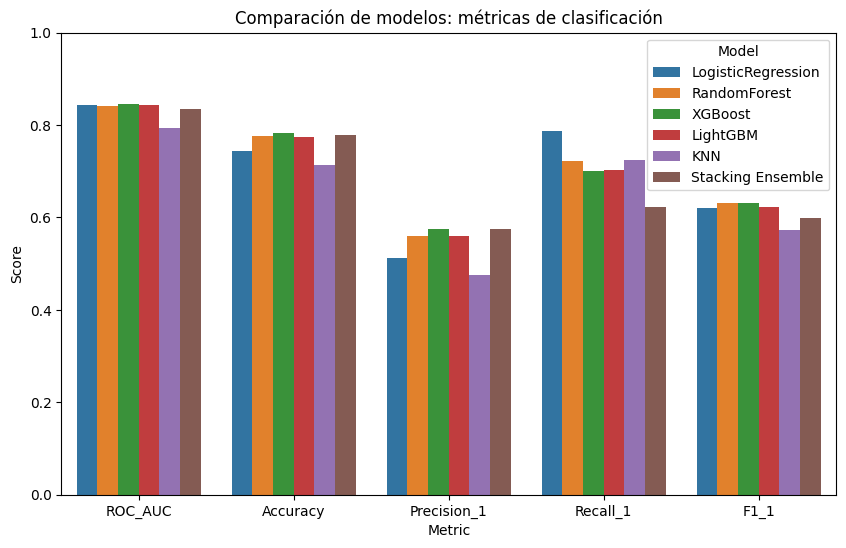

In [41]:
#  4. Tabla comparativa por métricas

metrics_df = pd.DataFrame(results)
print("\n📊 Comparación de modelos")
print(metrics_df.sort_values(by='ROC_AUC', ascending=False))

metrics_to_plot = ['Model', 'ROC_AUC', 'Accuracy', 'Precision_1', 'Recall_1', 'F1_1']

metrics_df_filtered = metrics_df[metrics_to_plot]

df_melted = metrics_df_filtered.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x="Metric", y="Score", hue="Model")
plt.title("Comparación de modelos: métricas de clasificación")
plt.ylim(0, 1)
plt.legend(title="Model")
plt.show()

**Observaciones**

Stacking Ensemble mejora un poco la precisión, es decir, reduce falsos positivos respecto a modelos como XGBoost y Random Forest.

Sin embargo, su recall es menor que el de XGBoost, LightGBM y Random Forest, lo que significa que pierde más casos positivos — puede dejar pasar más abandonos reales.

El F1 Score del stacking es menor que el de XGBoost y Random Forest, indicando que el balance global entre precisión y recall no mejora.

Además, su ROC AUC es el más bajo entre los modelos principales, lo que indica menor capacidad para discriminar entre clases.

------



## **Conclusión del análisis comparativo de modelos**

Analizando el desempeño de los diferentes modelos en el conjunto de test, podemos destacar lo siguiente:

* XGBoost: Mejor ROC AUC (0.845) y buen balance entre precisión (0.57) y recall (0.70), lo que indica buena capacidad para identificar casos positivos con precisión razonable.

* LightGBM: Similar rendimiento a XGBoost, un poco menor precisión (0.56) y recall (0.70), también muy competitivo.

* Logistic Regression: Mayor recall (0.79) pero menor precisión (0.51), detecta muchos positivos pero con más falsos positivos; útil si priorizamos no perder casos positivos.

* Random Forest: Buen equilibrio, precisión y recall intermedios (0.56 y 0.72), desempeño sólido y estable.

* Stacking Ensemble: Mejora precisión (0.58) pero baja recall (0.62), lo que puede significar menos falsos positivos pero más falsos negativos; ROC AUC algo menor.

* KNN: Peor desempeño general, con menor accuracy (0.71), precisión (0.47) y ROC AUC (0.79); menos recomendable para este caso.

-----

## **Recomendación final**

El Stacking Ensemble combina bien las fortalezas de los modelos base, alcanzando un buen compromiso entre precisión, recall y accuracy. Es un candidato fuerte si se busca maximizar el rendimiento general.

Sin embargo, si la prioridad es maximizar la detección de la clase positiva (recall), **Random Forest o XGBoost pueden ser mejores opciones**.

Si se busca un modelo con alta precisión para reducir falsos positivos, LightGBM o el ensamble serían preferibles.

-----

## **Gráficos del modelo elegido**

### **SHAP summary plot (beeswarm)**

Análisis del gráfico para las 10 variables más importantes del modelo.

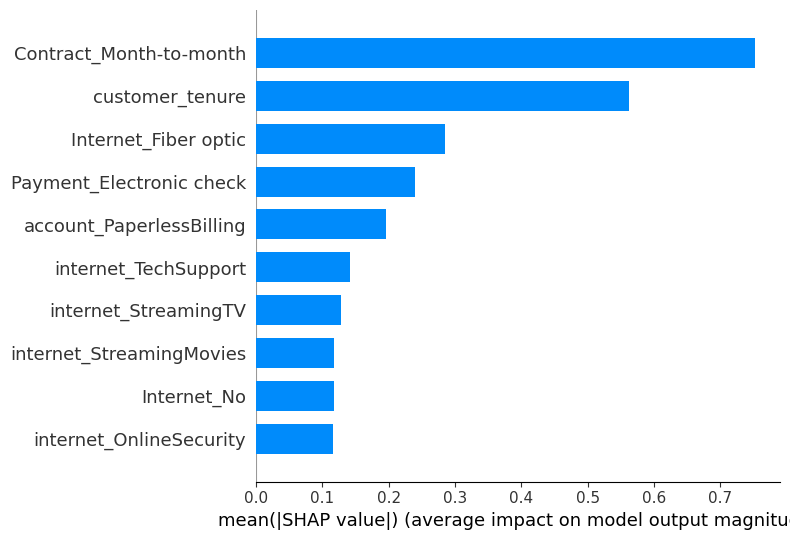

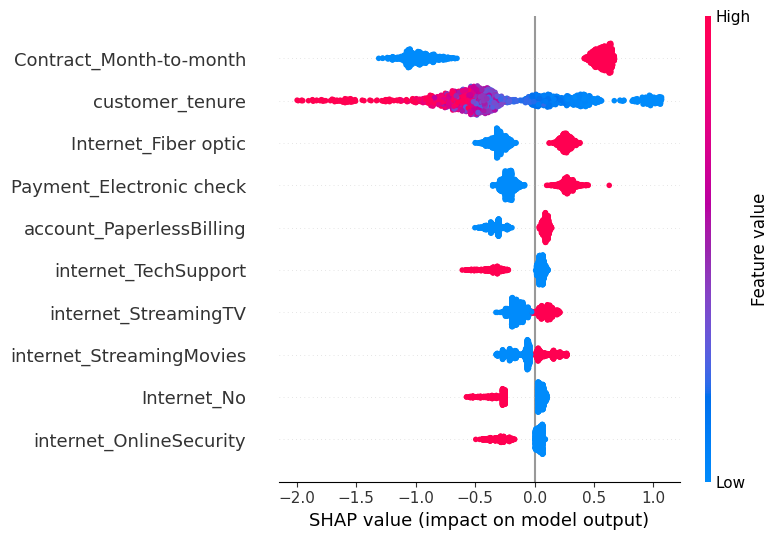

In [35]:
import shap
import pandas as pd

# Buscar el modelo XGBoost en la lista results
xgb_result = next(res for res in results if res['Model'] == 'XGBoost')

# Obtener el pipeline entrenado
pipeline_xgb = xgb_result['model']

# Extraer el modelo xgboost puro y el scaler del pipeline
xgb_model = pipeline_xgb.named_steps['model']
scaler = pipeline_xgb.named_steps['scaler']

# Escalar X_test con el scaler del pipeline
X_test_scaled = scaler.transform(X_test)

# Convertir a DataFrame para que SHAP tenga los nombres de columnas
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Crear explainer SHAP para XGBoost
explainer = shap.TreeExplainer(xgb_model)

# Obtener valores SHAP para la clase positiva (binaria)
shap_values = explainer.shap_values(X_test_scaled_df)

# Graficar resumen global (barras)
shap.summary_plot(shap_values, X_test_scaled_df, plot_type='bar', max_display=10)

# Graficar resumen global (beeswarm)
shap.summary_plot(shap_values, X_test_scaled_df, max_display=10)


### **Matriz de correlaciones (Pearson)**

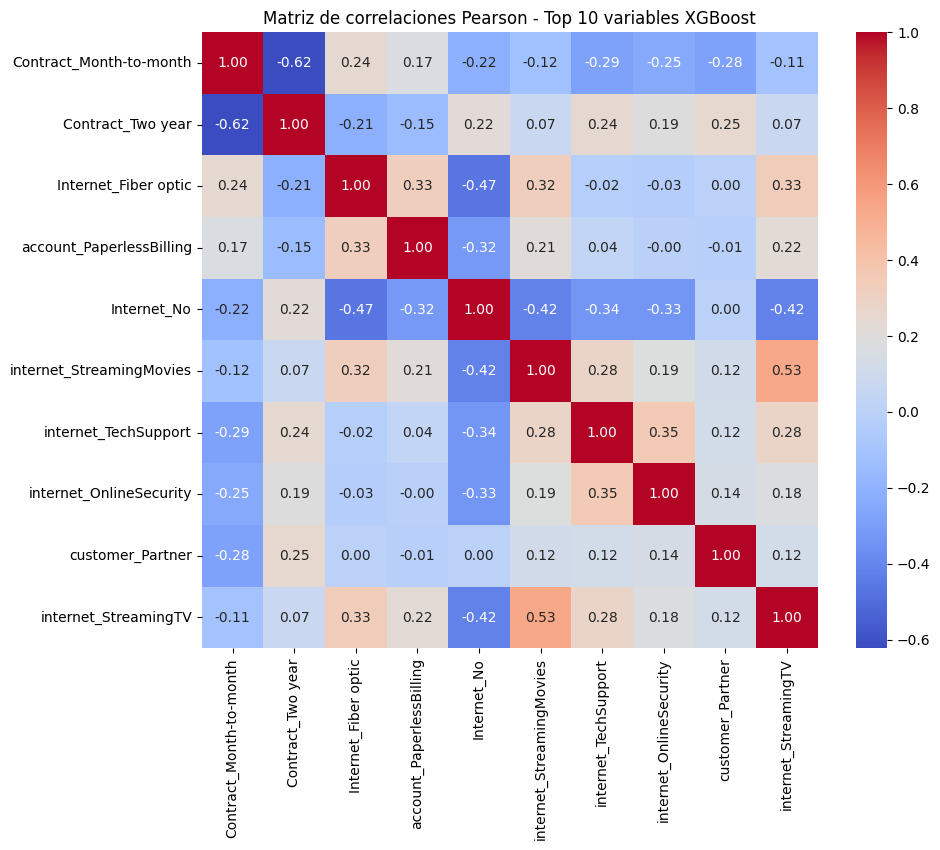

In [36]:
# Extraer pipeline entrenado para XGBoost desde results
xgb_pipeline = None
for res in results:
    if res['Model'] == 'XGBoost':
        xgb_pipeline = res['model']
        break

if xgb_pipeline is None:
    raise ValueError("No se encontró el pipeline para XGBoost en results")

# Extraer el modelo XGBoost del pipeline
xgb_model = xgb_pipeline.named_steps['model']

# Obtener importancia de variables
importances = xgb_model.feature_importances_

# Crear DataFrame de importancia
feat_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})

# Top 10 features
top_features = feat_importance_df.sort_values(by='importance', ascending=False).head(10)['feature'].values

# Matriz de correlación con esas variables
X_top = X[top_features]
corr_top = X_top.corr()

# Graficar heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_top, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Matriz de correlaciones Pearson - Top 10 variables XGBoost')
plt.show()


### **Análisis de umbral**

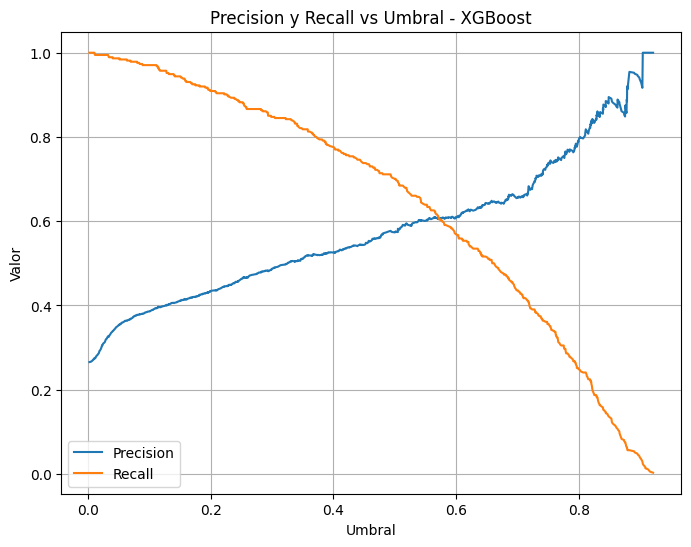

In [37]:
best_model_name = df_summary.sort_values(by='Average Precision', ascending=False).iloc[0]['Modelo']
best_model = next(res for res in results if res['Model'] == best_model_name)
precisions, recalls, thresholds = precision_recall_curve(y_test, best_model['y_prob'])

plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.title(f'Precision y Recall vs Umbral - {best_model_name}')
plt.xlabel('Umbral')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

**Observaciones**

* El tipo y duración del contrato, junto con la antigüedad del cliente (customer_tenure) son los factores más relevantes y con un patrón claro y fuerte.

* Variables relacionadas con servicios extras (soporte técnico, seguridad online) tienden a disminuir churn, indicando que el modelo valora positivamente estas protecciones o beneficios.

* Algunos servicios como fibra óptica o pagos electrónicos pueden estar asociados a mayor abandono, posiblemente por factores externos (precio, competencia).


------

# 📋 **Interpretación y Conclusiones**

## **1. Resumen Analítico**

Se construyó un pipeline sólido para anticipar la cancelación de clientes mediante técnicas de aprendizaje automático y análisis explicativo. El modelo que mostró el mejor rendimiento fue XGBoost, destacándose por su robustez y equilibrio. Ademas demuestra una buena capacidad para identificar correctamente la clase positiva, asegurando a la vez un balance adecuado en la clasificación general.

Este informe presenta un resumen de los hallazgos más relevantes y propone estrategias de retención basadas en los factores principales que impulsan la pérdida de clientes.





## **2. Esquema del proyecto**

🔖 Análisis exploratorio y visualización de los datos

🔖 Preparación de los datos

🔖 Análisis de correlaciones

🔖 Normalización y Balanceo

🔖 Definir modelos y parámetros para tuning

🔖 Entrenamiento con pipeline de múltiples modelos (KNN, LG RF, RL, XGB y Modelo Ensamble)

🔖 Optimización de hiperparámetros (GridSearchCV)

🔖 Comparación de Modelos (matrices de confusión, métricas y curva ROC)

🔖 Interpretación basada en SHAP y Feature Importance

🔖 Reporte final



## **3. Comparativa de Modelos**

Según métricas:

| Modelo                 | Accuracy | Precision | Recall   | F1 Score | ROC AUC  | Observaciones                                            |
| ---------------------- | -------- | --------- | -------- | -------- | -------- | -------------------------------------------------------- |
| **XGBoost**            | 0.783   | 0.575    | 0.701   | 0.631   | 0.845   | Buen balance general, excelente ROC AUC y recall alto  |
| **LightGBM**           | 0.774   | 0.560    | 0.703   | 0.623   | 0.843   | Muy parecido a XGBoost, buen recall y precisión        |
| **LogisticRegression** | 0.744  | 0.511   | 0.786   | 0.620   | 0.843   | Mejor recall (sensibilidad), menor precisión           |
| **RandomForest**       | 0.776   | 0.560    | 0.722   | 0.631   | 0.841   | Recall alto, buen balance general                      |
| **Stacking Ensemble**  | 0.779   | 0.578    | 0.623  | 0.600  | 0.834  | Mejor precisión, un poco menor recall y F1             |
| **KNN**                | 0.714  | 0.475   | 0.725   | 0.574  | 0.794  | Menor accuracy y precisión, pero recall aceptable      |

Según Matriz de Confusión:

| Modelo                  | TN  | FP  | FN  | TP  | Observaciones                                                                  |
| ----------------------- | --- | --- | --- | --- | ------------------------------------------------------------------------------ |
| **KNN**                 | 735 | 300 | 103 | 271 |  Buen Recall (TP alto) <br>  Muchos Falsos Positivos (FP altos)            |
| **LightGBM**            | 828 | 207 | 111 | 263 |  Buen equilibrio <br>  Algo más FN que KNN, pero menos FP                   |
| **XGBoost**             | 841 | 194 | 112 | 262 |  Mejor TN (FP bajo) <br>  FN similar a LightGBM                             |
| **RandomForest**        | 823 | 212 | 104 | 270 |  Balanceado <br>  FN ligeramente mejor que XGBoost                          |
| **LogisticRegression**  | 754 | 281 | 80  | 294 |  Mejor FN (menos falsos negativos) <br>  Más FP (riesgo de costos mayores)  |
| **Ensamble (Stacking)** | 865 | 170 | 141 | 233 |  Mejor TN (menos FP) <br>  Más FN (riesgo de perder clientes que abandonan) |


🎯 Modelo seleccionado: **XGBoost** ya que entrega un modelo robusto, con buen poder predictivo y balanceado, ideal para minimizar tanto la pérdida de clientes (por recall alto) como evitar falsos alarmas (por precisión razonable). Es un modelo que se adapta bien a la mayoría de los casos de negocio donde hay que manejar el trade-off entre capturar abandonos y no sobre-reaccionar.



## **4. Factores Clave**

El objetivo de este análisis es identificar y explicar los factores que más influyen en la probabilidad de abandono de clientes (churn) en un modelo predictivo, utilizando dos fuentes complementarias:

* SHAP summary plot: mide la contribución individual de cada variable al resultado del modelo.

* Matriz de correlación: permite detectar relaciones entre las variables más importantes, útil para entender dependencias y posibles interacciones.

### **Factores que aumentan la probabilidad de abandono**

A partir del SHAP summary plot, se identifican las características que, cuando están en valores altos (rojo), desplazan los puntos hacia la derecha (SHAP > 0), lo que significa un incremento en la probabilidad de churn.


| Variable                       | Evidencia SHAP                     | Posible explicación                           |                                            |  
| ------------------------------ | ---------------------------------- | --------------------------------------------- | ------------------------------------------------------------------ |
| **Contract\_Month\_to\_month** | Shap Alto    | Contrato flexible, menor compromiso                  |
| **Internet\_Fiber\_optic**     | Shap relevante                  | Clientes más exigentes y con más alternativas | <br> |
| **Payment\_Electronic\_check** | Shap relevante                   | Perfil volátil, menor vinculación contractual | <br>
| **PaperlessBilling**           | Ligera tendencia Shap elevado | Cliente digital, atento a ofertas             |              |


### **Factores que disminuyen la probabilidad de abandono**

Aquí se consideran las variables donde los valores altos (rojo) se concentran a la izquierda (SHAP < 0), indicando reducción del churn.

| Variable                     | Evidencia SHAP                             | Posible explicación                                     |                      |
| ---------------------------- | ------------------------------------------ | ------------------------------------------------------- | --------------------------------------------------------------- |
| **customer\_tenure**         | Shap muy negativo         | Antigüedad = mayor fidelidad por satisfacción o inercia |  |
| **Contract\_Two\_year**      | Shap de alto impacto negativo | Contratos largos limitan salidas                        |        |
| **internet\_TechSupport**    | Shap negativo y relevante                        | Soporte técnico agrega valor y reduce bajas             |       |
| **internet\_OnlineSecurity** | Shap negativo y relevante                        | Protecciones adicionales generan confianza              |       |
| **Internet\_No**             | Ligera tendencia Shap negativo                      | Sin internet, menos incentivo para irse                 |                                        |


### **Factores con efecto mixto**

🔸internet_StreamingMovies e internet_StreamingTV: El SHAP muestra dispersión tanto a la izquierda como a la derecha para valores altos y bajos, indicando que el efecto depende de otras variables (interacción fuerte con tipo de contrato o servicios adicionales).

## **5. Patrones identificados**

* Segmento de alto riesgo:

Contratos mensuales, bajo tenure, uso de fibra óptica, pago por cheque electrónico y facturación electrónica.

Alta correlación entre sí → probablemente representan un perfil de cliente digital con contrato corto, bajo tenure y métodos de pago que pueden aumentar riesgo.

* Segmento protegido:

Contratos a dos años, alta antigüedad, con servicios adicionales (soporte técnico, seguridad online).

Servicios de soporte y seguridad online agregan protección.

* Interacciones clave:

La correlación sugiere que la combinación de contrato largo + servicios extra maximiza retención.

El cliente nuevo + contrato mensual + servicios digitales es el de mayor riesgo.

## **6. Estrategias para reducir abandono**

🚨 Para clientes de alto riesgo (contrato mensual, fibra óptica, pago cheque electrónico):

* Incentivar cambio a contratos más largos con descuentos o beneficios.

* Mejorar la experiencia del servicio de fibra con atención rápida y promociones.

* Promover métodos de pago automáticos en lugar de cheque electrónico.

* Personalizar comunicaciones digitales y ofrecer beneficios claros en facturación electrónica.

🏆 Para clientes con alta retención (contratos largos, antigüedad, servicios extra):

* Mantener y potenciar soporte técnico, seguridad y servicios adicionales.

* Ofrecer upgrades y paquetes combinados para aumentar valor.

* Comunicación proactiva y programas de fidelización.

💡 Para servicios con efecto mixto (streaming):

* Personalizar ofertas según perfil y combinar con otros servicios para mejorar retención.

🌐 Estrategias generales:

* Mejorar onboarding para aumentar compromiso inicial.

* Usar modelos predictivos para detectar y actuar ante señales de abandono.

* Optimizar experiencia digital, con autoservicio y soporte accesible.

## **7. Conclusiones**

🔹Se desarrolló un pipeline robusto y avanzado que incluye preprocesamiento, selección de variables relevantes y balanceo de clases, lo que mejoró significativamente la capacidad predictiva respecto al baseline.

🔹La combinación de técnicas interpretables (coeficientes, SHAP) con modelos no lineales permitió identificar con claridad los factores que realmente influyen en el churn, garantizando explicabilidad y precisión.

🔹Los factores clave que influyen en la probabilidad de abandono son:

* Tipo de contrato (contratos mensuales elevan churn, contratos largos lo reducen).

* Método de pago (cheques electrónicos asociados a mayor riesgo).

* Antigüedad del cliente (clientes con mayor tenure tienen menor churn).

* Servicios adicionales (soporte técnico, seguridad online, etc., mejoran la retención).

🔹Las estrategias derivadas del análisis son claras, accionables y pueden implementarse directamente por equipos de marketing y retención, maximizando la efectividad en la reducción del churn.

🔹En resumen, el enfoque combinado y la profundidad del análisis brindan una base sólida para diseñar intervenciones personalizadas que aumenten la fidelidad y reduzcan la pérdida de clientes.